In [205]:
#!pip install geopandas matplotlib
#!pip install wget
#!pip install wordcloud
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import missingno as msno
import os
import wget
import openpyxl
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as font_manager
import geopandas as gpd
from shapely.geometry import Polygon

<AxesSubplot:>

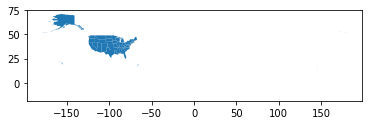

In [206]:

# Replace with the path to your downloaded shapefile
shapefile_path = '/Users/chenjin/Library/CloudStorage/OneDrive-UniversityofPittsburgh/2023Fall/IV/final/cb_2018_us_state_500k/cb_2018_us_state_500k.shx'

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

gdf.plot()


In [207]:
#gdf

/var/folders/n_/2_08cx9j54l9v4h7jwztlpt80000gs/T/ipykernel_74847/2920071404.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


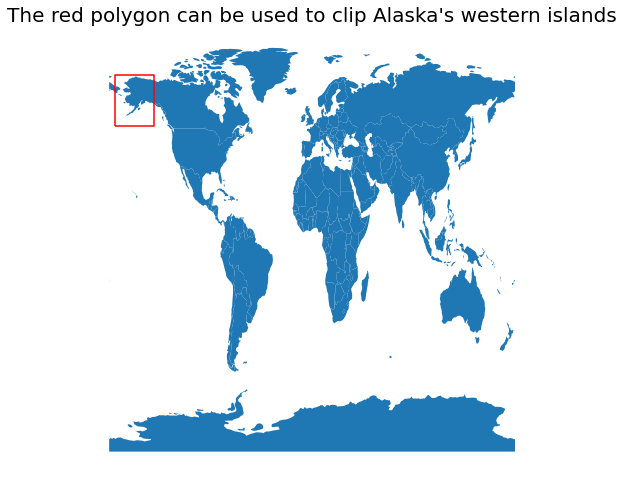

In [208]:
# map adjusment reference: https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# NOTE: the convention for polygon points is (Long, Lat)....counterintuitive
polygon = Polygon([(-175,50),(-175,72),(-140, 72),(-140,50)])


poly_gdf = gpd.GeoDataFrame( geometry=[polygon], crs=world.crs)

fig, ax1 = plt.subplots(1, figsize=(8, 18))
world.plot(ax=ax1)
poly_gdf.boundary.plot(ax = ax1, color="red")
ax1.set_title("The red polygon can be used to clip Alaska's western islands", fontsize=20)
ax1.set_axis_off()
plt.show()

   STATEFP   STATENS     AFFGEOID GEOID STUSPS    NAME LSAD          ALAND  \
27      02  01785533  0400000US02    02     AK  Alaska   00  1478839695958   

          AWATER                                           geometry  
27  245481577452  MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...  


<AxesSubplot:>

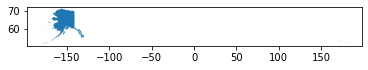

In [209]:
alaska_gdf = gdf[gdf.STUSPS=='AK']
hawaii_gdf = gdf[gdf.STUSPS=='HI']
print(alaska_gdf)
alaska_gdf.plot()

   STATEFP   STATENS     AFFGEOID GEOID STUSPS    NAME LSAD        ALAND  \
42      15  01779782  0400000US15    15     HI  Hawaii   00  16633990195   

         AWATER                                           geometry  
42  11777809026  MULTIPOLYGON (((-156.06076 19.73055, -156.0566...  


<AxesSubplot:>

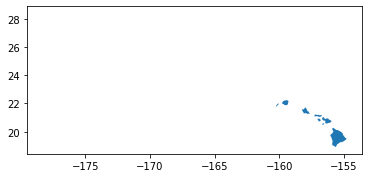

In [210]:
print(hawaii_gdf)
hawaii_gdf.plot()

<AxesSubplot:>

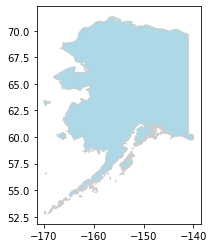

In [211]:
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])

alaska_gdf.clip(polygon).plot( color='lightblue', linewidth=0.8, edgecolor='0.8')

<AxesSubplot:>

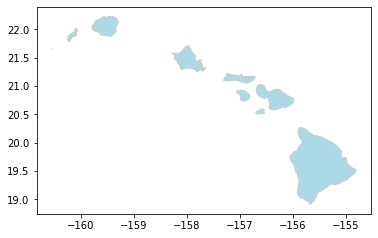

In [212]:
hipolygon = Polygon([(-161,0),(-161,90),(-120,90),(-120,0)])
hawaii_gdf.clip(hipolygon).plot(color='lightblue', linewidth=0.8, edgecolor='0.8')

/Users/chenjin/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


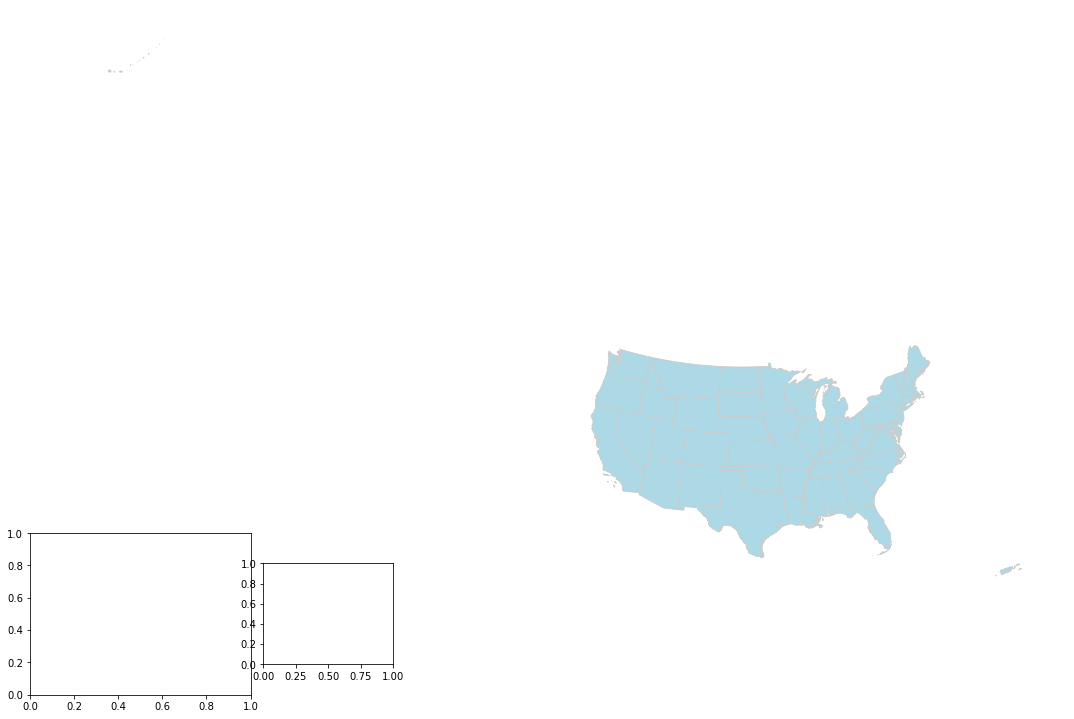

In [213]:
# Create a "copy" of gdf for re-projecting
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box from the main map
ax.axis('off')


# create map of all states except AK and HI in the main map axis
visframe[~visframe.STUSPS.isin(['HI','AK'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')


# Add Alaska Axis (x, y, width, height)
akax = fig.add_axes([0.1, 0.17, 0.17, 0.16])   


# Add Hawaii Axis(x, y, width, height)
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   

# We'll later map Alaska in "akax" and Hawaii in "hiax"

In [214]:
df = pd.read_csv('/Users/chenjin/Library/CloudStorage/OneDrive-UniversityofPittsburgh/2023Fall/IV/final/GenrebyState.csv')

In [215]:
print(df.dtypes)

# Remove the '%' sign and convert to numeric
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col].str.replace('%', '')) / 100


Region     object
Pop        object
Rock       object
Hiphop     object
Country    object
Blues      object
dtype: object


In [216]:
# Add the new column
df['FavoriteGenre'] = df.loc[:, 'Pop':'Blues'].idxmax(axis=1)
df.head()
print(df.dtypes)


Region            object
Pop              float64
Rock             float64
Hiphop           float64
Country          float64
Blues            float64
FavoriteGenre     object
dtype: object


In [217]:
gdf = gdf.merge(df,left_on='NAME',right_on='Region')

In [218]:
gdf
# Define the mapping from 'FavoriteGenre' to 'SimpleGenre'
genre_mapping = {
    'Pop': 'P',
    'Rock': 'R',
    'Hiphop': 'H',
    'Country': 'C',
    'Blues': 'B'
}

# Apply the mapping to the 'FavoriteGenre' column to create the new 'SimpleGenre' column
gdf['SimpleGenre'] = gdf['FavoriteGenre'].map(genre_mapping)

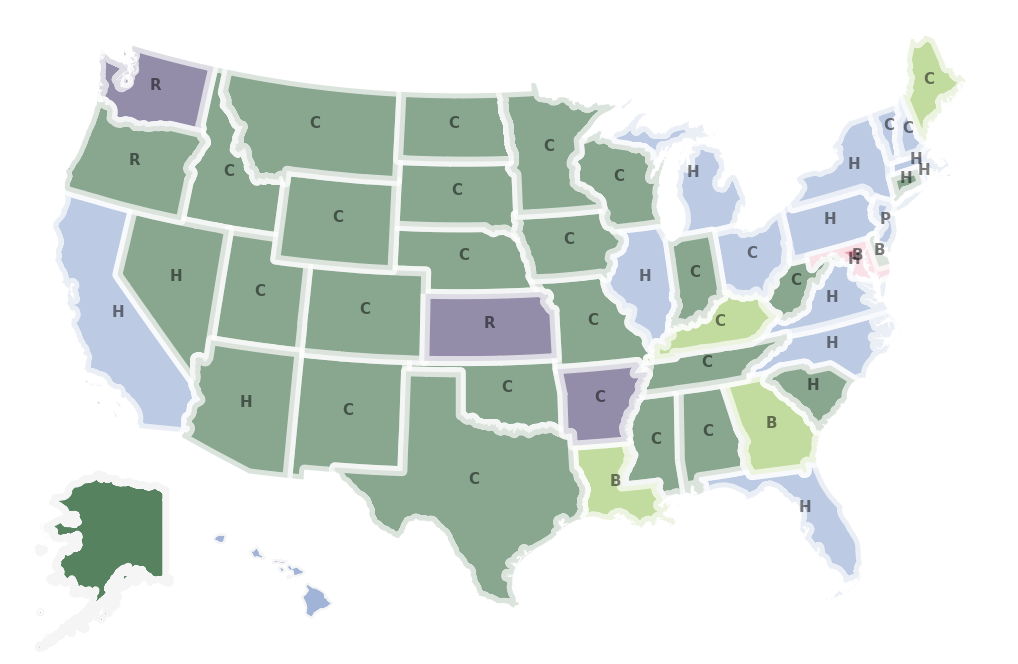

In [219]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Assuming 'gdf' is your GeoDataFrame and it is already loaded with the 'FavoriteGenre' column.

# Re-project to a suitable projection for USA maps
visframe = gdf.to_crs(epsg=2163)

# Define colors for each music genre
genre_colors = {
    'Pop': '#e47594',
    'Rock': '#665e86',
    'Hiphop': '#a1b4d8',
    'Country': '#56825f',
    'Blues': '#a9cd75'
}

# Map the colors to the 'FavoriteGenre' column
visframe['color'] = visframe['FavoriteGenre'].map(genre_colors)

# Create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off')

# Plot the mainland states except AK and HI
visframe[~visframe['STUSPS'].isin(['HI', 'AK'])].plot(color=visframe['color'],alpha=0.7, linewidth=10, ax=ax, edgecolor='1')

# Add the genre text to the mainland states
for idx, row in visframe[~visframe['STUSPS'].isin(['HI', 'AK'])].iterrows():
    centroid = row.geometry.centroid
    plt.annotate(text=row['SimpleGenre'], xy=(centroid.x, centroid.y), horizontalalignment='center',fontsize=15, fontstyle='normal', weight='bold',color='BLACK',alpha=0.5)


# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color='#56825f',linewidth=7,ax=akax, edgecolor='0.96')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(color='#a1b4d8',linewidth=2,ax=hiax, edgecolor='0.96')


# Show the plot
plt.show()


In [220]:
#visframe['color']

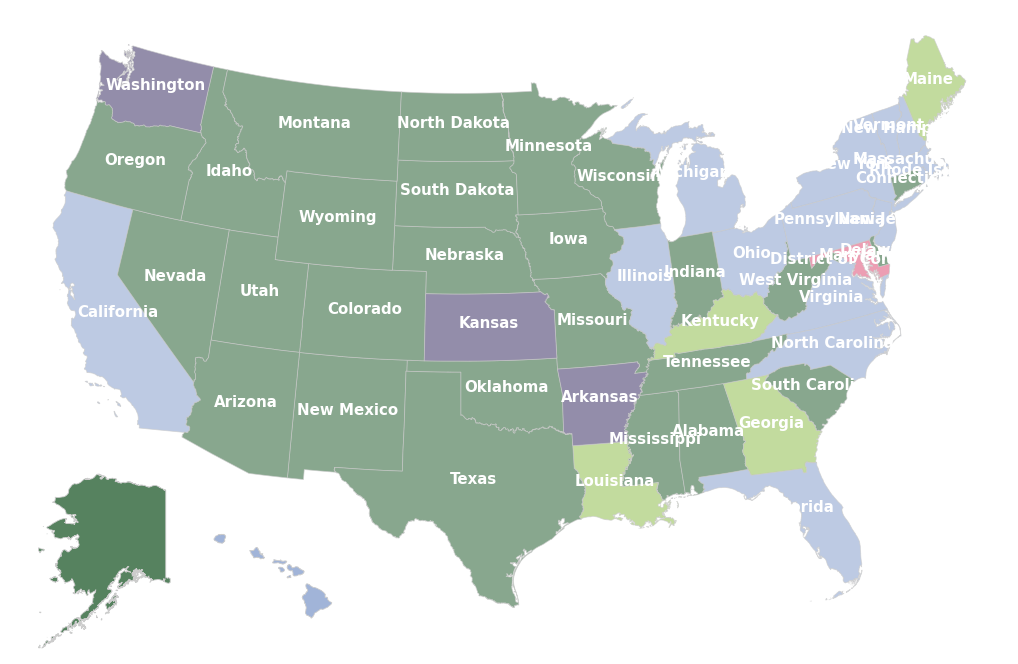

In [221]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Assuming 'gdf' is your GeoDataFrame and it is already loaded with the 'FavoriteGenre' column.

# Re-project to a suitable projection for USA maps
visframe = gdf.to_crs(epsg=2163)

# Define colors for each music genre
genre_colors = {
    'Pop': '#e47594',
    'Rock': '#665e86',
    'Hiphop': '#a1b4d8',
    'Country': '#56825f',
    'Blues': '#a9cd75'
}

# Map the colors to the 'FavoriteGenre' column
visframe['color'] = visframe['FavoriteGenre'].map(genre_colors)

# Create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off')

# Plot the mainland states except AK and HI
visframe[~visframe['STUSPS'].isin(['HI', 'AK'])].plot(color=visframe['color'],alpha=0.7, linewidth=0.8, ax=ax, edgecolor='0.8')

# Add the genre text to the mainland states
for idx, row in visframe[~visframe['STUSPS'].isin(['HI', 'AK'])].iterrows():
    centroid = row.geometry.centroid
    plt.annotate(text=row['NAME'], xy=(centroid.x, centroid.y), horizontalalignment='center',fontsize=15, fontstyle='normal', weight='bold',color='white')


# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color='#56825f',linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(color='#a1b4d8',linewidth=0.8,ax=hiax, edgecolor='0.8')


# Show the plot
plt.show()


In [239]:
len(gdf[gdf["FavoriteGenre"]=="Country"])
   

27

In [223]:
gdf[gdf["NAME"]=="Kentucky"]

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,Region,Pop,Rock,Hiphop,Country,Blues,FavoriteGenre,SimpleGenre
42,21,01779786,0400000US21,21,KY,Kentucky,00,102279490672,2375337755,"MULTIPOLYGON (((-89.40565 36.52817, -89.39869 ...",Kentucky,0.09,0.2,0.21,0.37,0.13,Country,C


In [224]:
gdf[gdf.STUSPS=='AK']

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,Region,Pop,Rock,Hiphop,Country,Blues,FavoriteGenre,SimpleGenre
26,02,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...",Alaska,0.11,0.26,0.22,0.27,0.14,Country,C


In [225]:
gdf[gdf.STUSPS=='HI']

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,Region,Pop,Rock,Hiphop,Country,Blues,FavoriteGenre,SimpleGenre
39,15,01779782,0400000US15,15,HI,Hawaii,00,16633990195,11777809026,"MULTIPOLYGON (((-156.06076 19.73055, -156.0566...",Hawaii,0.12,0.17,0.26,0.24,0.21,Hiphop,H


In [226]:
gdf[gdf["NAME"]=="Kentucky"]

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,Region,Pop,Rock,Hiphop,Country,Blues,FavoriteGenre,SimpleGenre
42,21,01779786,0400000US21,21,KY,Kentucky,00,102279490672,2375337755,"MULTIPOLYGON (((-89.40565 36.52817, -89.39869 ...",Kentucky,0.09,0.2,0.21,0.37,0.13,Country,C


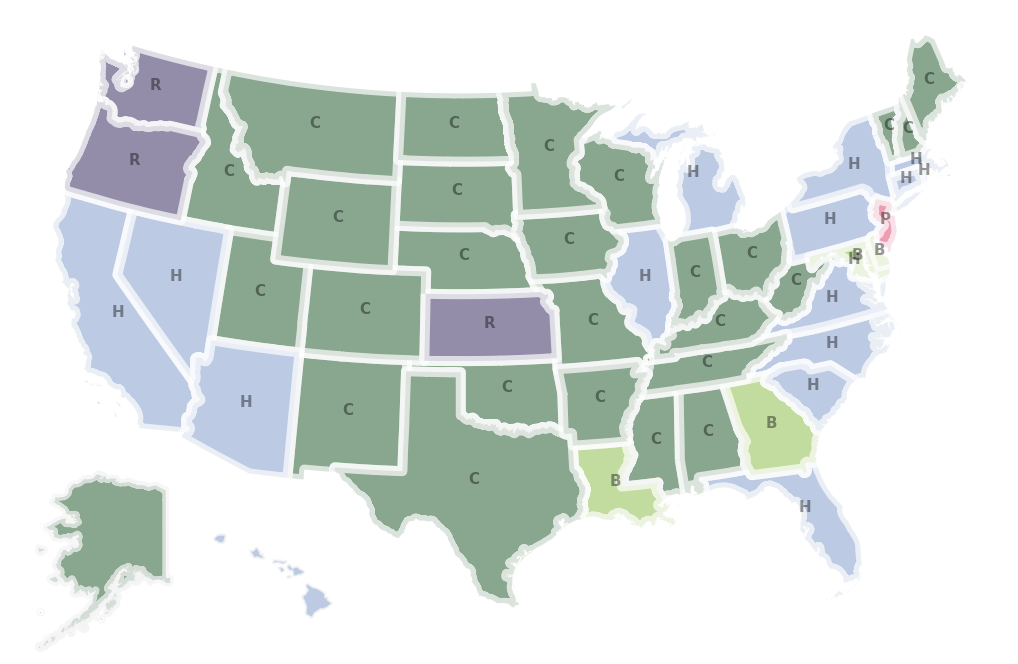

In [227]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Assuming 'gdf' is your GeoDataFrame and it is already loaded with the 'FavoriteGenre' column.

# Re-project to a suitable projection for USA maps
visframe = gdf.to_crs(epsg=2163)

# Define colors for each music genre
genre_colors = {
    'Pop': '#e47594',
    'Rock': '#665e86',
    'Hiphop': '#a1b4d8',
    'Country': '#56825f',
    'Blues': '#a9cd75'
}

# Map the colors to the 'FavoriteGenre' column
visframe['color'] = visframe['FavoriteGenre'].map(genre_colors)

# Create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off')

# Plot the mainland states except AK and HI
visframe[~visframe['STUSPS'].isin(['HI', 'AK'])].plot(color=visframe[~visframe['STUSPS'].isin(['HI', 'AK'])]['color'],alpha=0.7, linewidth=10, ax=ax, edgecolor='1')

# Add the genre text to the mainland states
for idx, row in visframe[~visframe['STUSPS'].isin(['HI', 'AK'])].iterrows():
    centroid = row.geometry.centroid
    plt.annotate(text=row['SimpleGenre'], xy=(centroid.x, centroid.y), horizontalalignment='center',fontsize=15, fontstyle='normal', weight='bold',color='BLACK',alpha=0.4)


# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color='#56825f',linewidth=7,ax=akax, edgecolor='0.96', alpha=0.7)


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(color='#a1b4d8',linewidth=2,ax=hiax, edgecolor='0.96', alpha=0.7)


# Show the plot
plt.show()


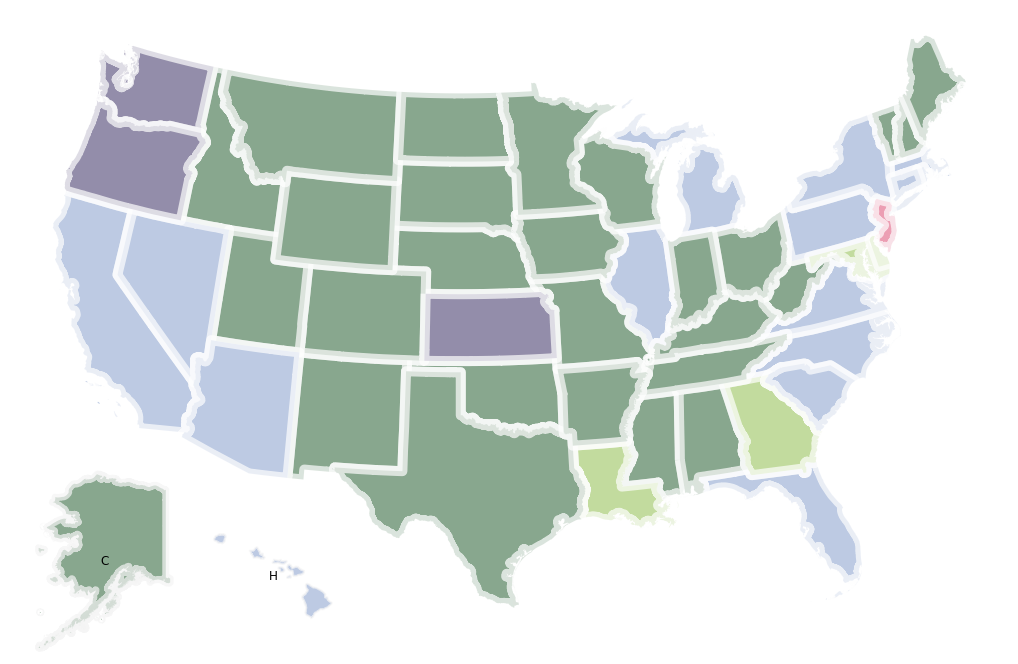

In [228]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Assuming 'gdf' is your GeoDataFrame and it is already loaded with the 'FavoriteGenre' column.

# Re-project to a suitable projection for USA maps
visframe = gdf.to_crs(epsg=2163)

# Define colors for each music genre
genre_colors = {
    'Pop': '#e47594',
    'Rock': '#665e86',
    'Hiphop': '#a1b4d8',
    'Country': '#56825f',
    'Blues': '#a9cd75'
}

# Map the colors to the 'FavoriteGenre' column
visframe['color'] = visframe['FavoriteGenre'].map(genre_colors)

# Create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off')

# Plot the mainland states except AK and HI
visframe[~visframe['STUSPS'].isin(['HI', 'AK'])].plot(color=visframe[~visframe['STUSPS'].isin(['HI', 'AK'])]['color'],alpha=0.7, linewidth=10, ax=ax, edgecolor='1')




# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color='#56825f',linewidth=7,ax=akax, edgecolor='0.96', alpha=0.7)


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(color='#a1b4d8',linewidth=2,ax=hiax, edgecolor='0.96', alpha=0.7)

# Add text "C" in the middle of the Alaska subplot
akax.text(0.5, 0.5, 'C', horizontalalignment='center', verticalalignment='center', 
          fontsize=12, transform=akax.transAxes)

# Add text "H" in the middle of the Hawaii subplot
hiax.text(0.5, 0.5, 'H', horizontalalignment='center', verticalalignment='center', 
          fontsize=12, transform=hiax.transAxes)

# Show the plot
plt.show()


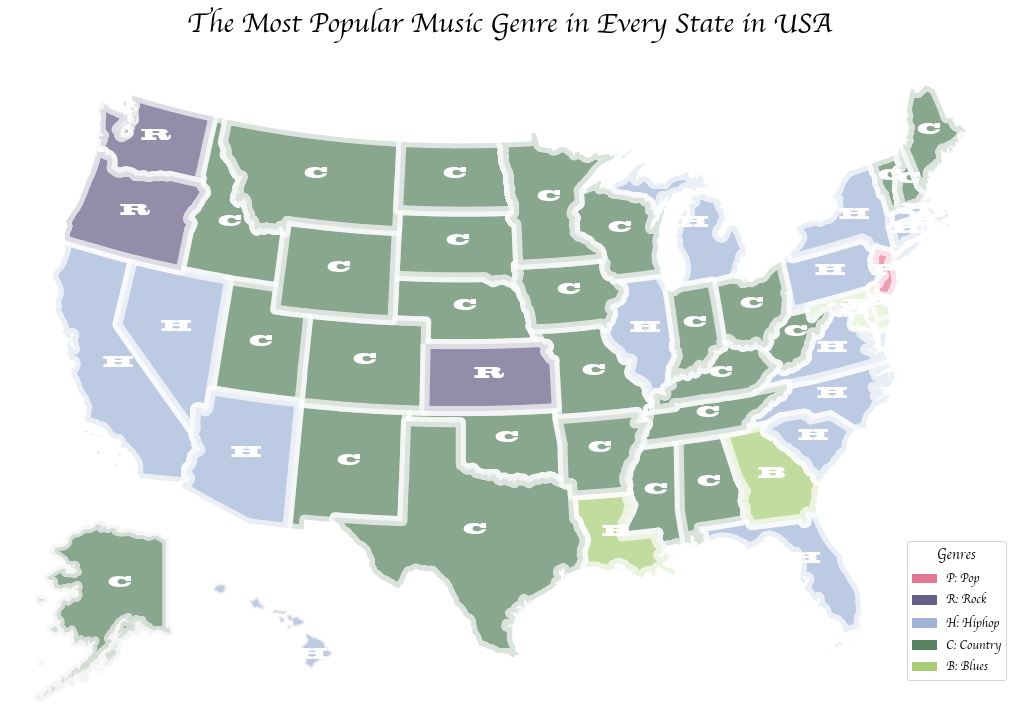

In [235]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Assuming 'gdf' is your GeoDataFrame and it is already loaded with the 'FavoriteGenre' column.

# Re-project to a suitable projection for USA maps
visframe = gdf.to_crs(epsg=2163)

# Define colors for each music genre
genre_colors = {
    'Pop': '#e47594',
    'Rock': '#665e86',
    'Hiphop': '#a1b4d8',
    'Country': '#56825f',
    'Blues': '#a9cd75'
}

# Map the colors to the 'FavoriteGenre' column
visframe['color'] = visframe['FavoriteGenre'].map(genre_colors)

# Create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off')

# Plot the mainland states except AK and HI
visframe[~visframe['STUSPS'].isin(['HI', 'AK'])].plot(color=visframe[~visframe['STUSPS'].isin(['HI', 'AK'])]['color'],alpha=0.7, linewidth=10, ax=ax, edgecolor='1')

# Add the genre text to the mainland states
for idx, row in visframe[~visframe['STUSPS'].isin(['HI', 'AK'])].iterrows():
    centroid = row.geometry.centroid
    plt.annotate(text=row['SimpleGenre'], xy=(centroid.x, centroid.y), horizontalalignment='center',fontsize=15, family = 'Blackoak Std', fontstyle='italic', weight='bold',color='white',alpha=1)


# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color='#56825f',linewidth=7,ax=akax, edgecolor='0.96', alpha=0.7)


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(color='#a1b4d8',linewidth=2,ax=hiax, edgecolor='0.95', alpha=0.7)

# Add text "C" in the middle of the Alaska subplot
akax.text(0.6, 0.65, 'C', horizontalalignment='center', verticalalignment='center', 
          fontsize=15, transform=akax.transAxes, color='white',family = 'Blackoak Std', fontstyle='italic', weight='bold')

# Add text "H" in the middle of the Hawaii subplot
hiax.text(0.8, 0.2, 'H', horizontalalignment='center', verticalalignment='center', 
          fontsize=15, transform=hiax.transAxes, color='white',family = 'Blackoak Std',fontstyle='italic', weight='bold')

# Define the font properties for the legend items
item_font_prop = font_manager.FontProperties(family='Apple Chancery', size=12)

# Define the font properties for the legend title
title_font_prop = font_manager.FontProperties(family='Apple Chancery', size=14, weight='bold')

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color='#e47594', label='P: Pop'),
    mpatches.Patch(color='#665e86', label='R: Rock'),
    mpatches.Patch(color='#a1b4d8', label='H: Hiphop'),
    mpatches.Patch(color='#56825f', label='C: Country'),
    mpatches.Patch(color='#a9cd75', label='B: Blues')
]

# Add the legend to the figure with the specified font properties
legend = ax.legend(handles=legend_patches, loc='lower right', title='Genres', prop=item_font_prop)
plt.setp(legend.get_title(), fontproperties=title_font_prop)

ax.set_title('The Most Popular Music Genre in Every State in USA',size=28, color='black', weight='bold',y=1.03, family='Apple Chancery')

# Show the plot
plt.show()


In [230]:
# import matplotlib.font_manager

# fonts = sorted({f.name for f in matplotlib.font_manager.fontManager.ttflist})
# for font in fonts:
#     print(font)

.Aqua Kana
.Keyboard
.New York
.SF Arabic
.SF Compact
.SF Compact Rounded
.SF NS Mono
.SF NS Rounded
Academy Engraved LET
Adobe Arabic
Adobe Caslon Pro
Adobe Devanagari
Adobe Fan Heiti Std
Adobe Fangsong Std
Adobe Garamond Pro
Adobe Gothic Std
Adobe Gurmukhi
Adobe Hebrew
Adobe Heiti Std
Adobe Kaiti Std
Adobe Ming Std
Adobe Myungjo Std
Adobe Naskh
Adobe Song Std
Al Bayan
Al Nile
Al Tarikh
Aloisen New
American Typewriter
Andale Mono
Apple Braille
Apple Chancery
Apple SD Gothic Neo
Apple Symbols
AppleGothic
AppleMyungjo
Arial
Arial Black
Arial Hebrew
Arial Narrow
Arial Rounded MT Bold
Arial Unicode MS
Athelas
Avenir
Avenir Next
Avenir Next Condensed
Ayuthaya
Baghdad
Bangla MN
Bangla Sangam MN
Baskerville
Batang
Beirut
Big Caslon
Birch Std
Blackoak Std
Bodoni 72
Bodoni 72 Oldstyle
Bodoni 72 Smallcaps
Bodoni Ornaments
Bookshelf Symbol 7
Bradley Hand
Brush Script MT
Brush Script Std
Calibri
Cambria
Cambria Math
Candara
Chalkboard
Chalkboard SE
Chalkduster
Chaparral Pro
Charlemagne Std
Charte

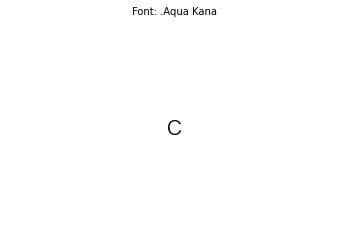

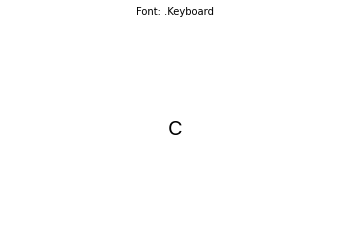

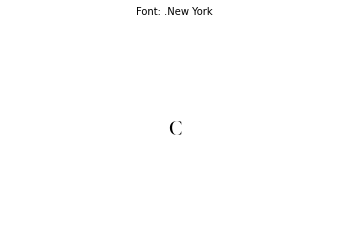

/Users/chenjin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chenjin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chenjin/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 67 (C) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


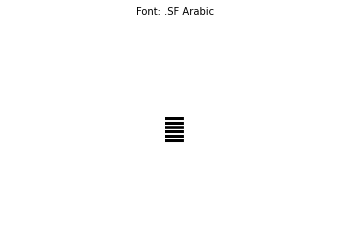

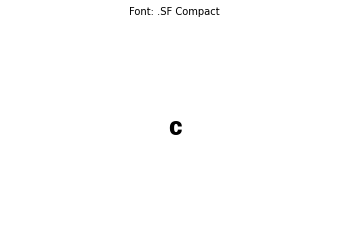

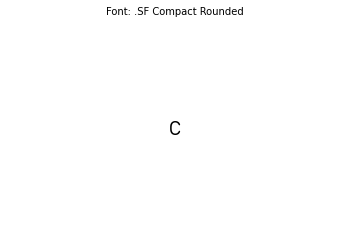

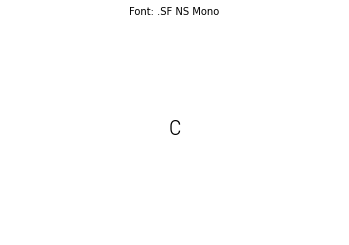

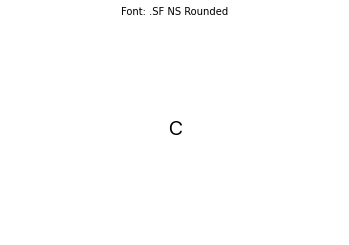

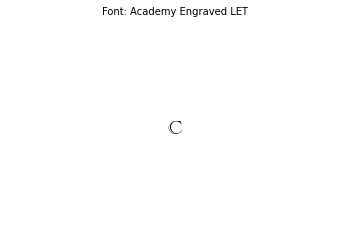

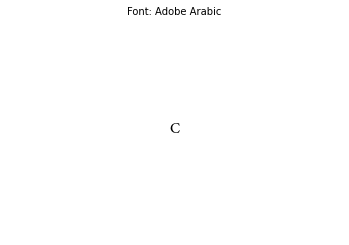

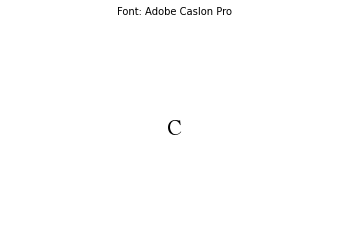

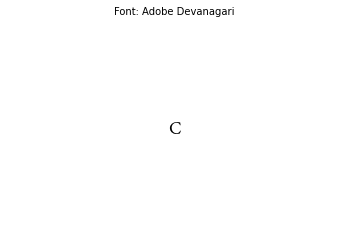

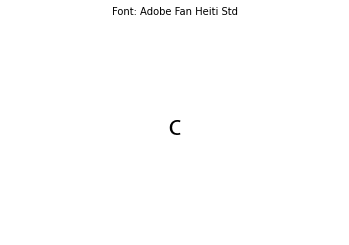

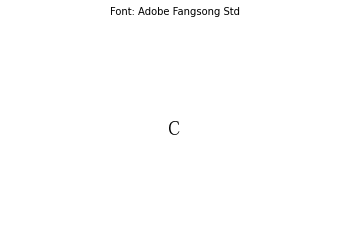

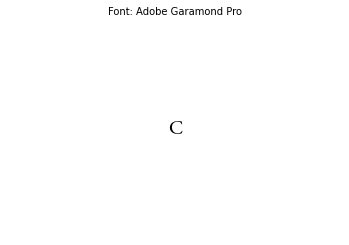

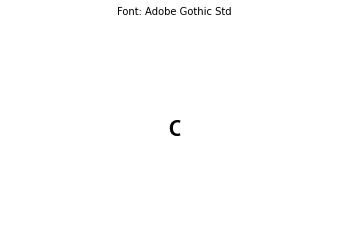

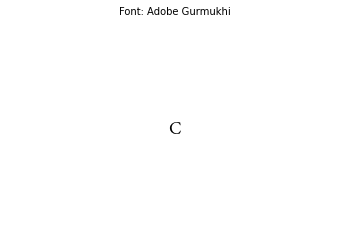

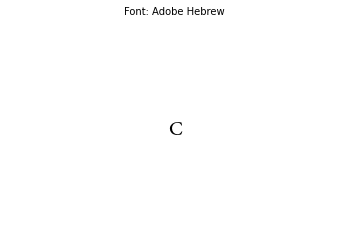

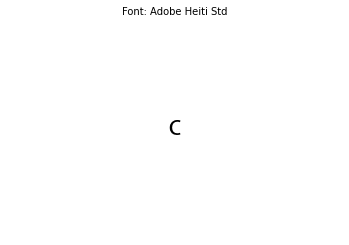

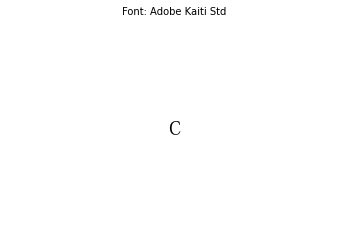

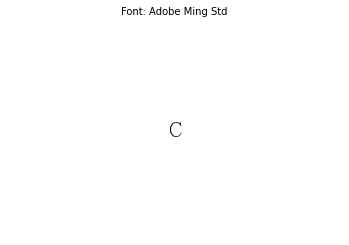

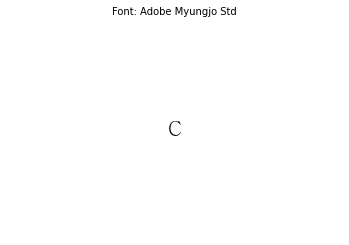

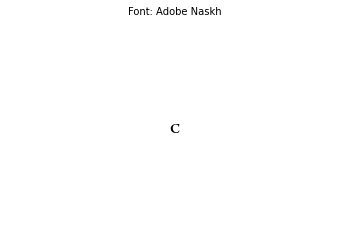

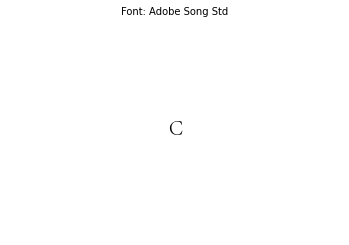

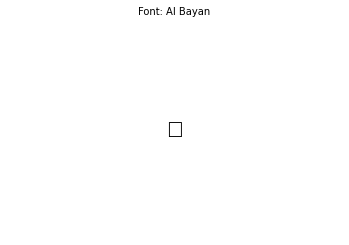

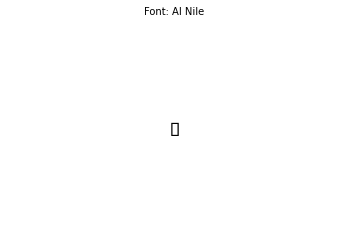

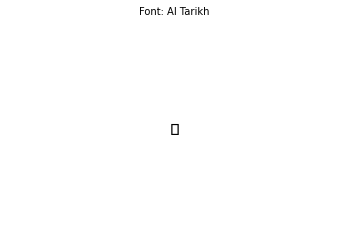

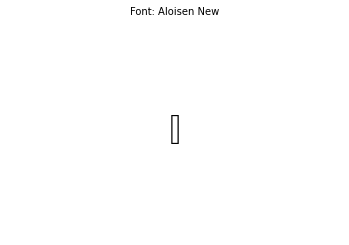

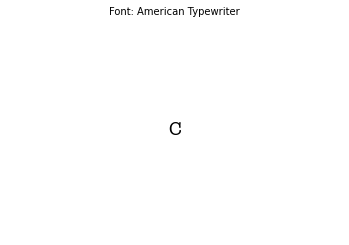

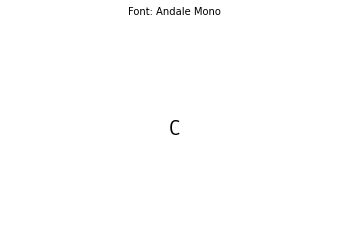

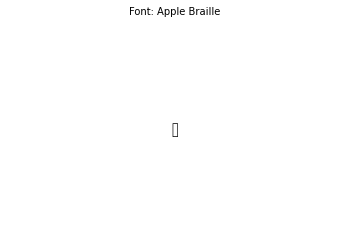

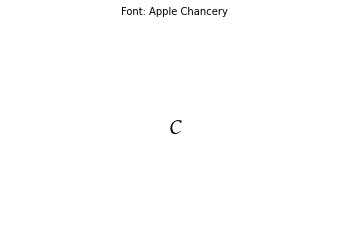

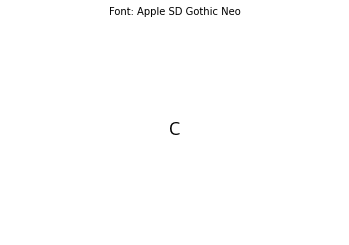

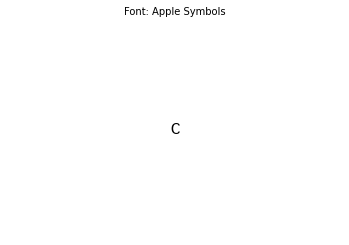

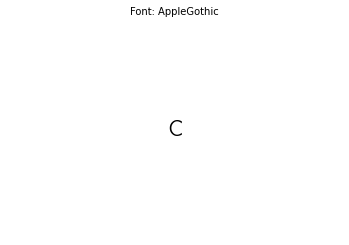

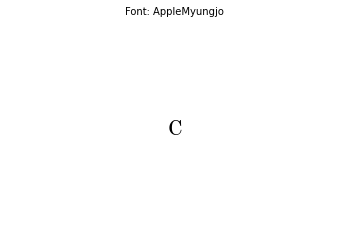

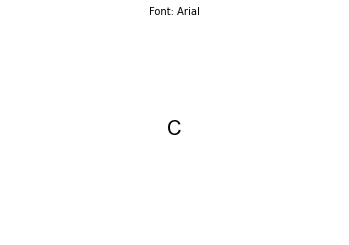

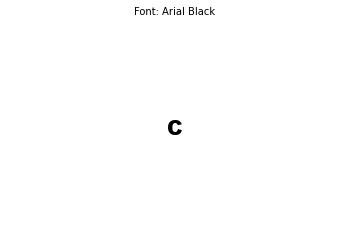

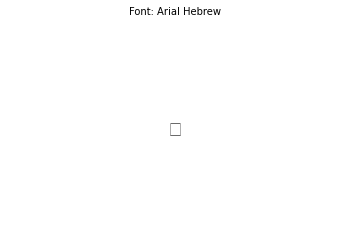

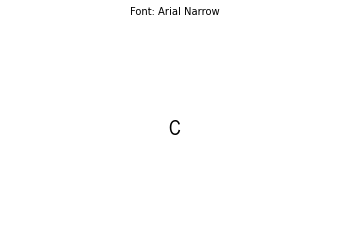

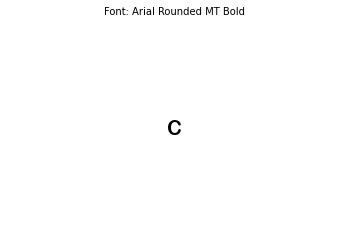

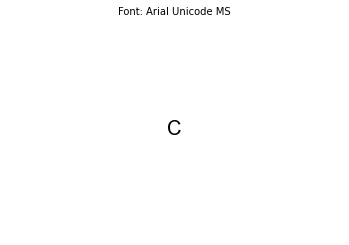

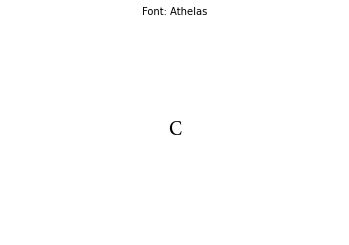

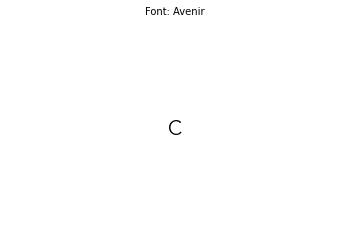

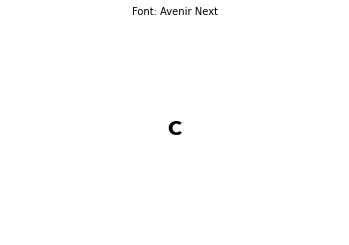

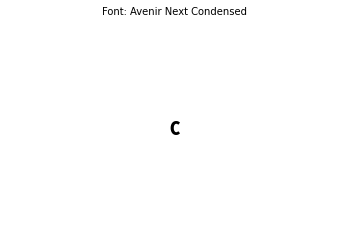

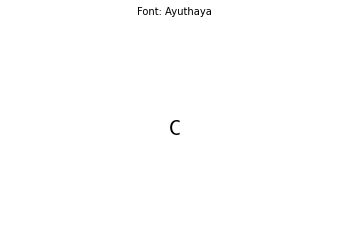

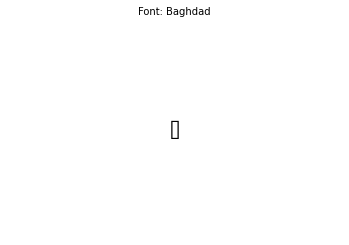

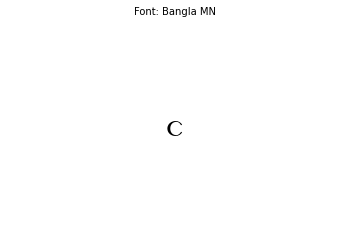

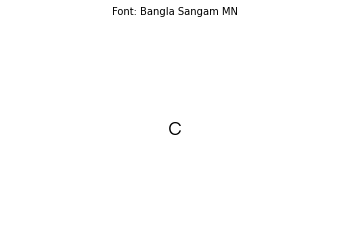

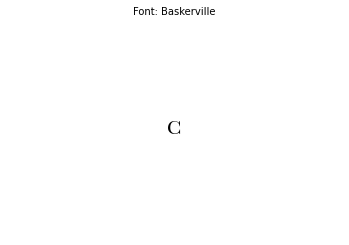

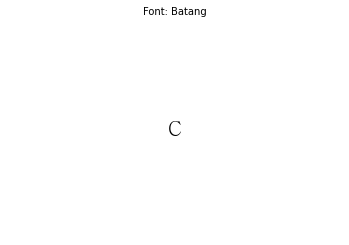

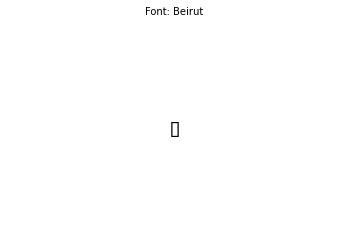

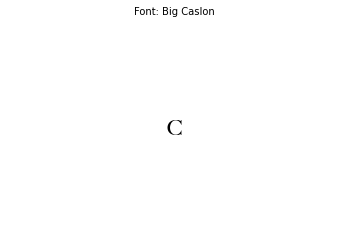

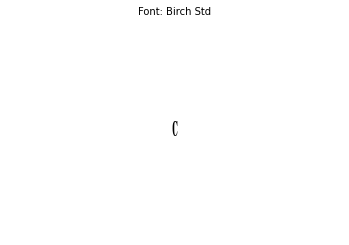

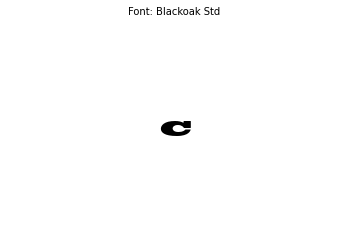

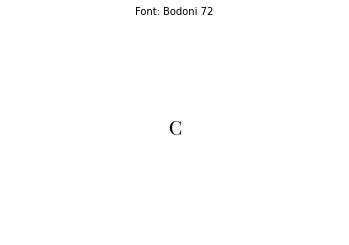

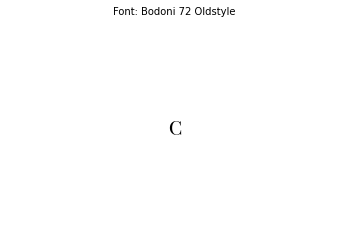

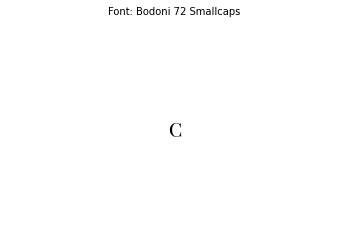

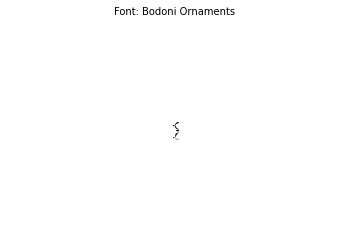

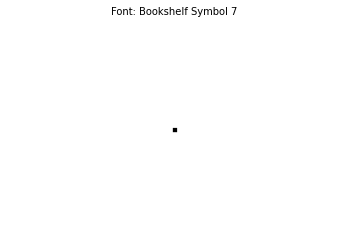

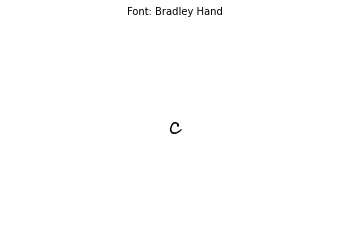

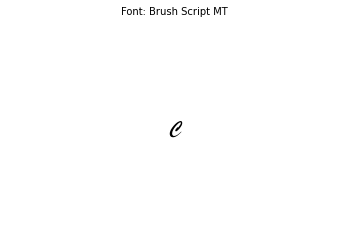

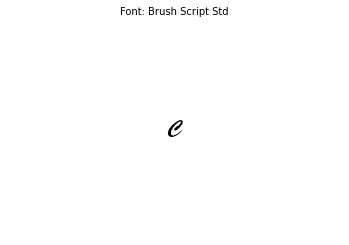

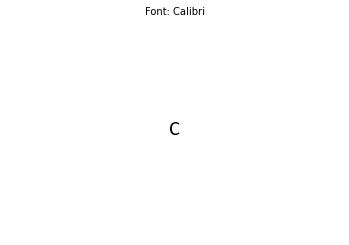

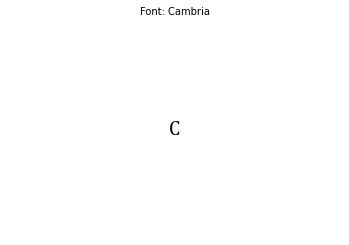

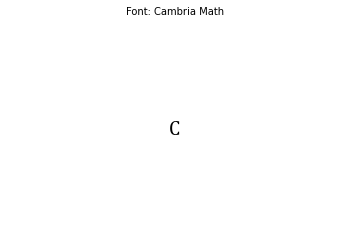

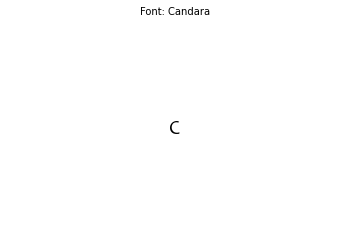

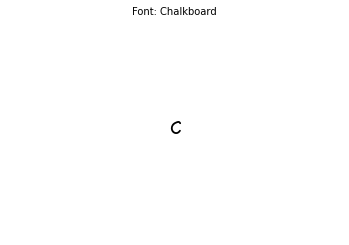

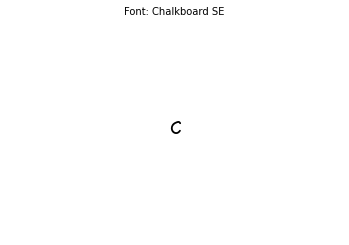

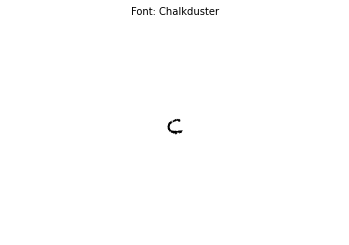

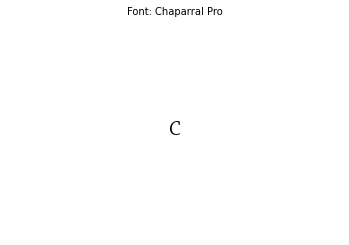

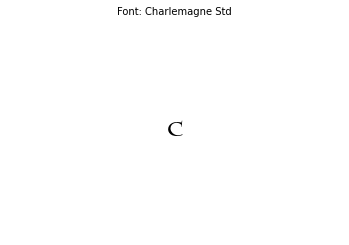

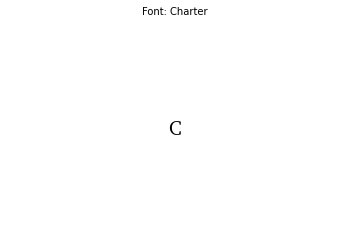

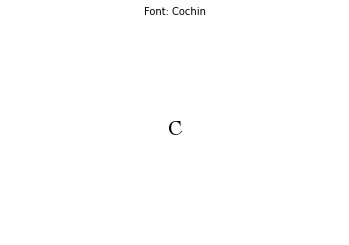

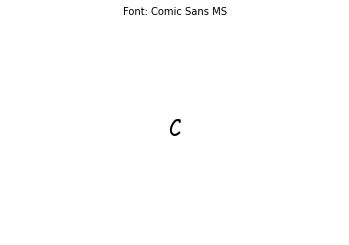

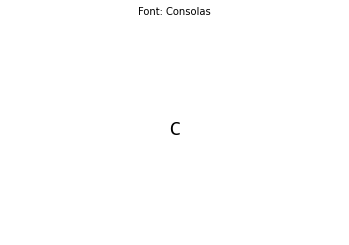

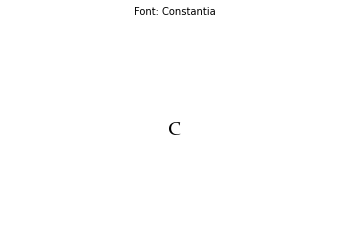

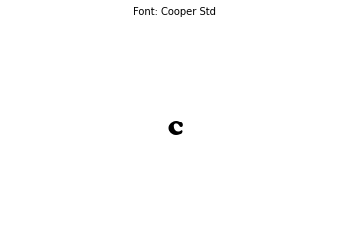

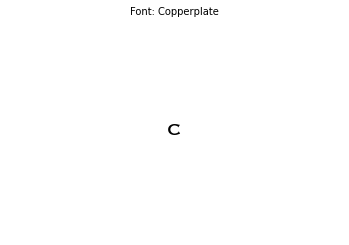

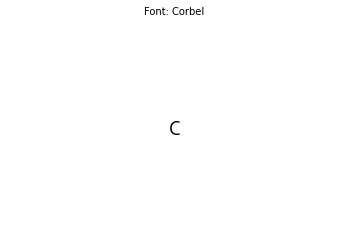

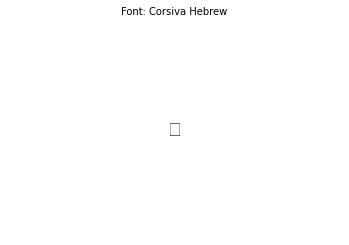

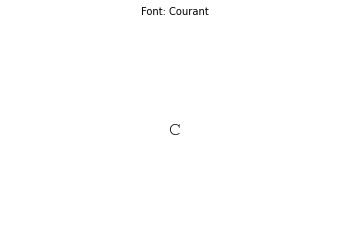

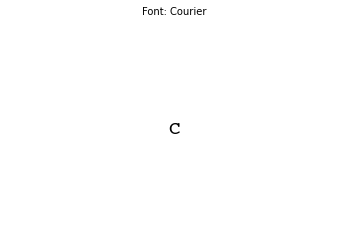

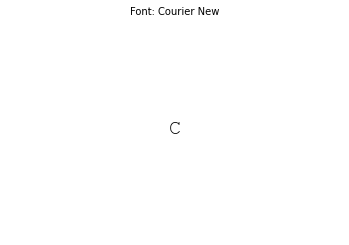

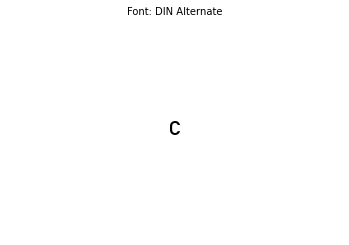

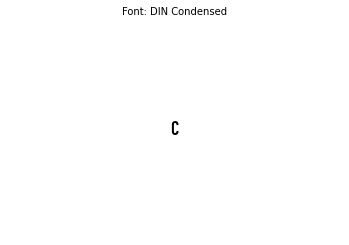

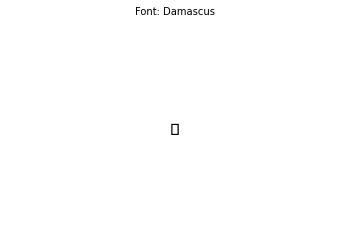

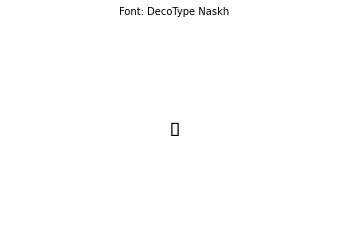

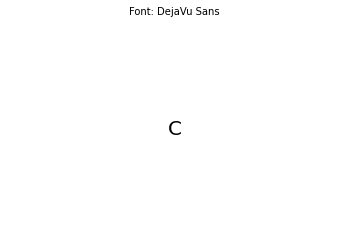

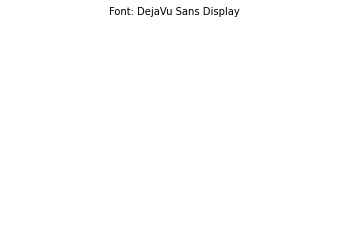

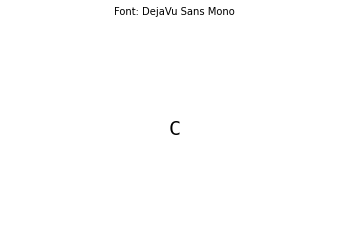

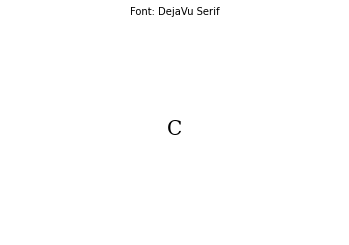

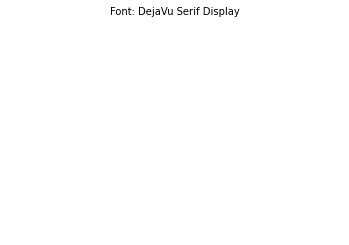

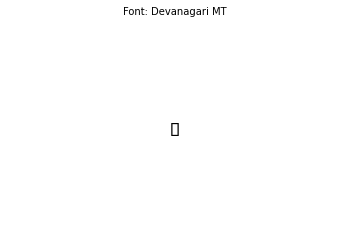

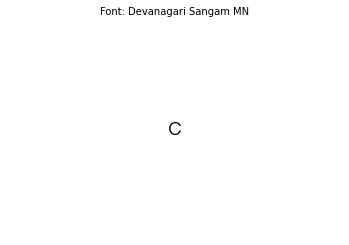

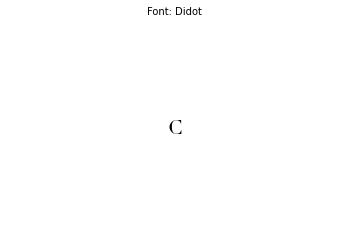

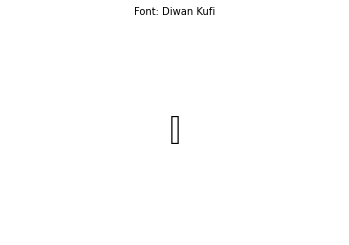

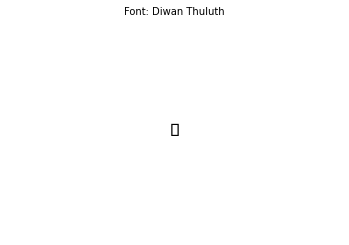

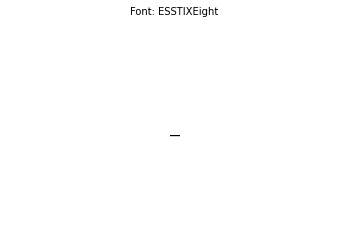

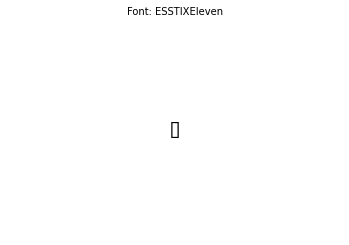

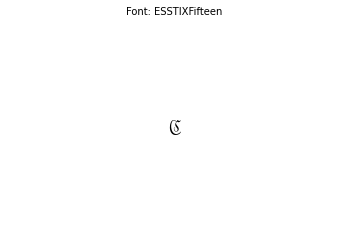

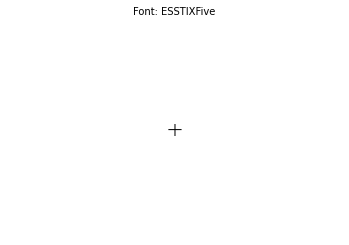

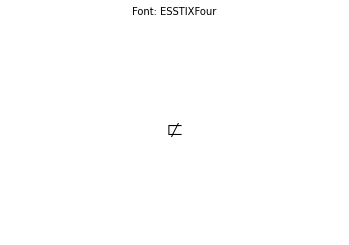

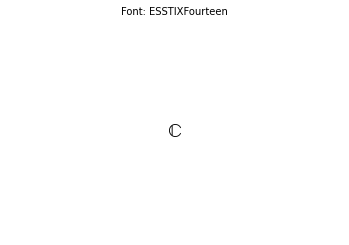

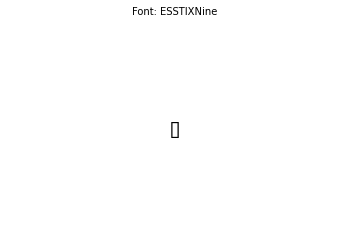

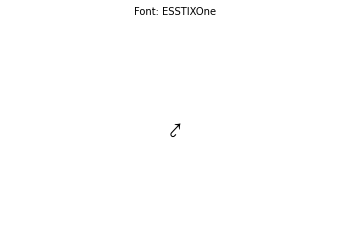

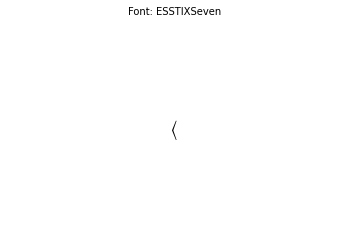

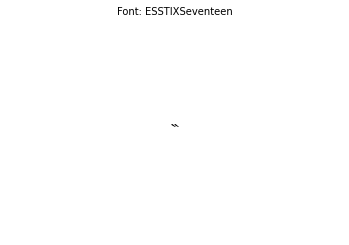

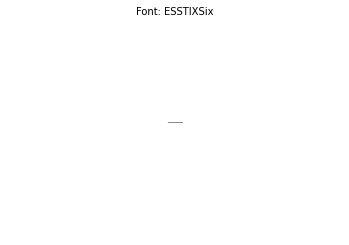

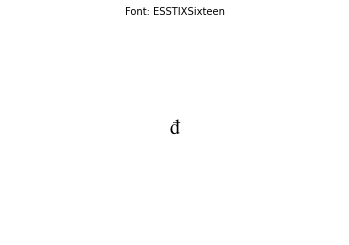

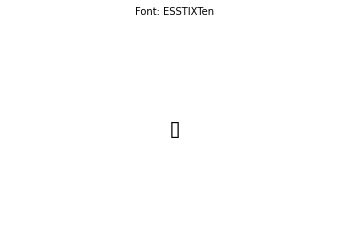

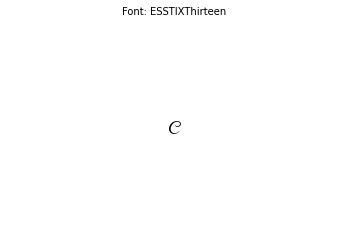

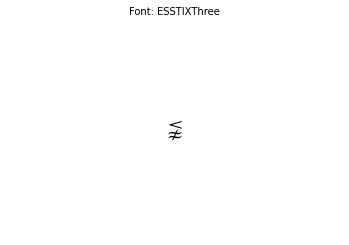

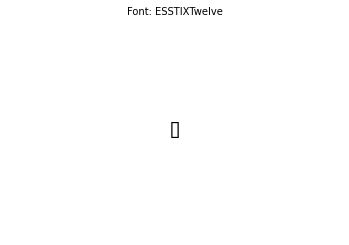

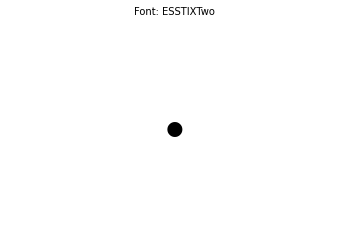

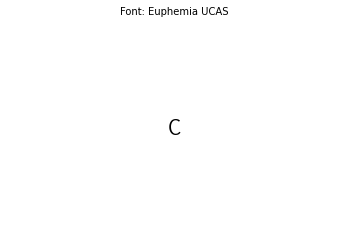

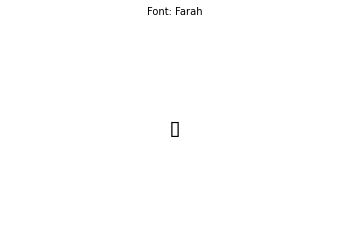

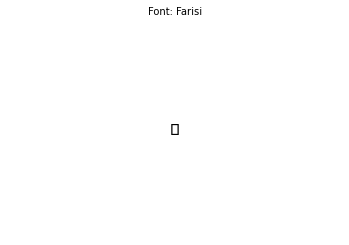

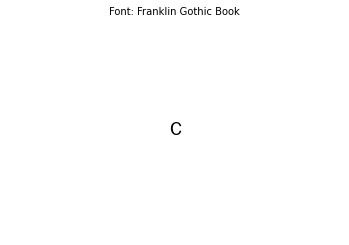

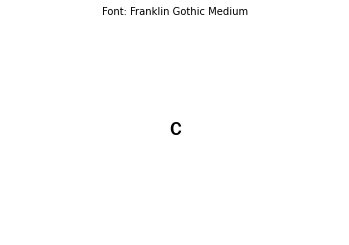

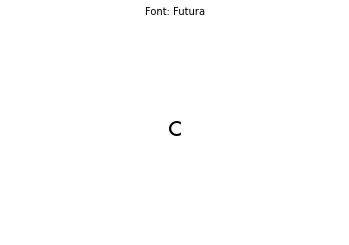

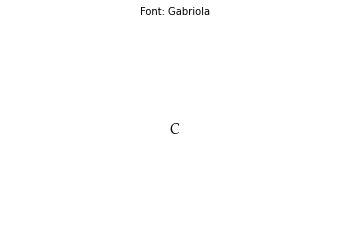

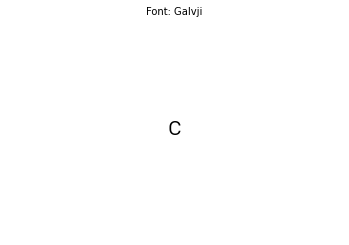

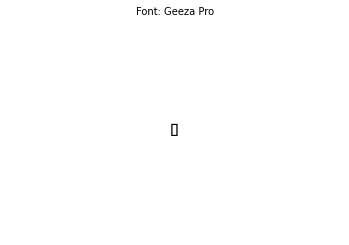

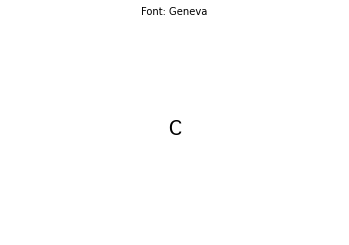

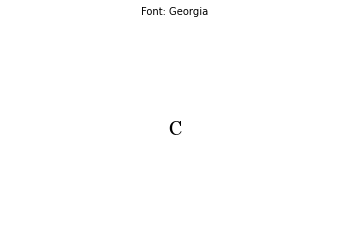

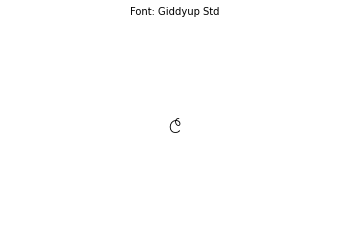

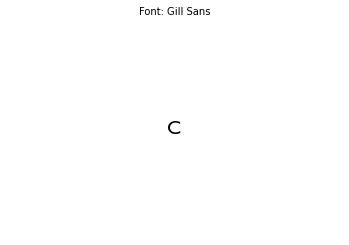

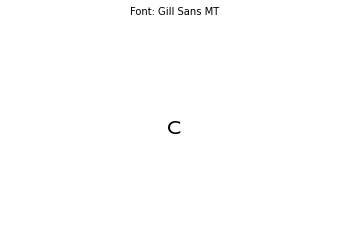

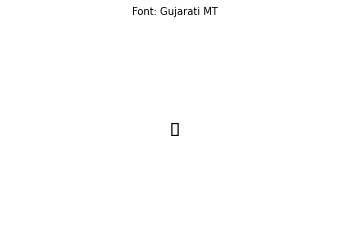

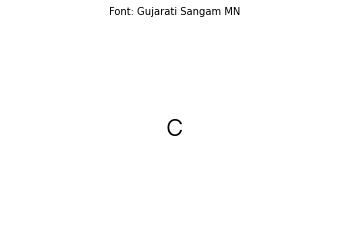

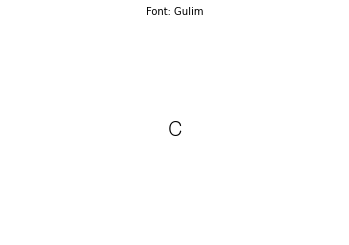

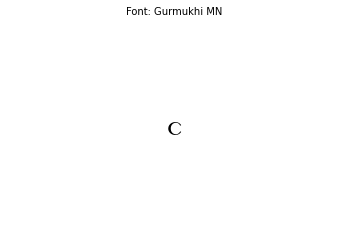

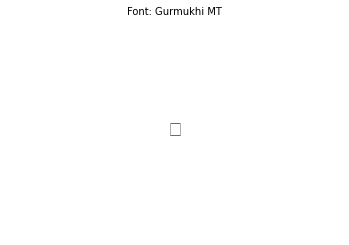

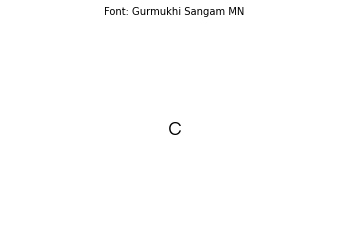

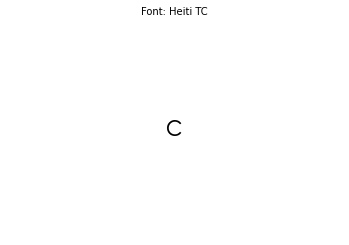

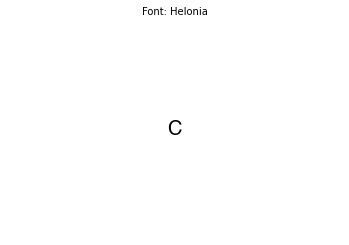

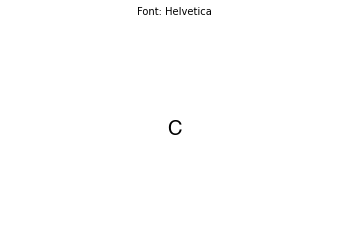

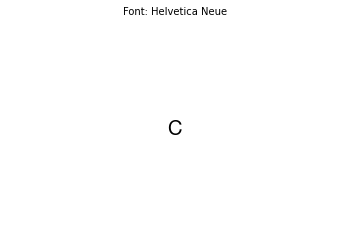

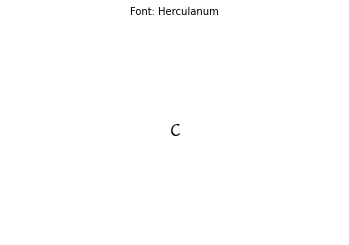

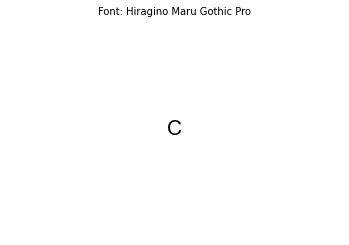

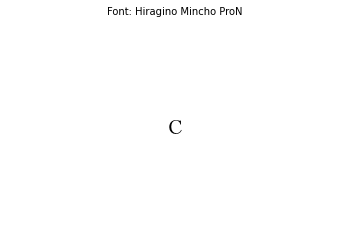

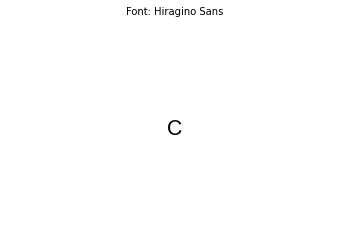

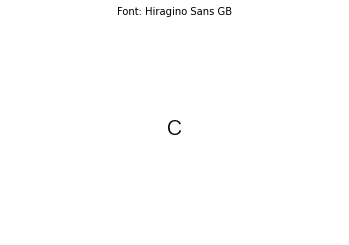

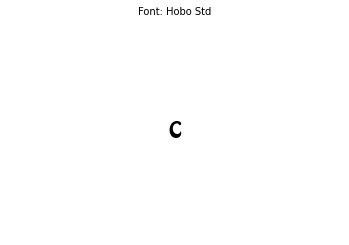

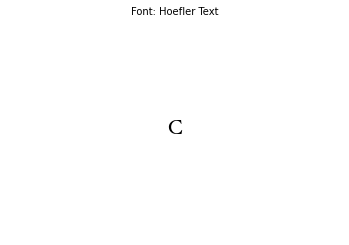

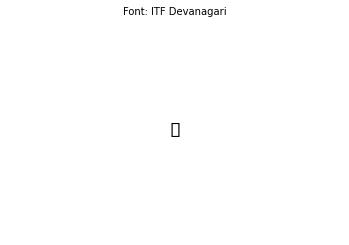

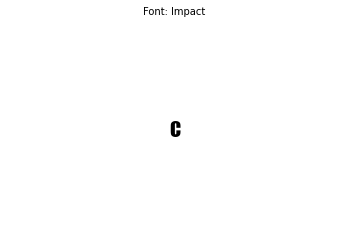

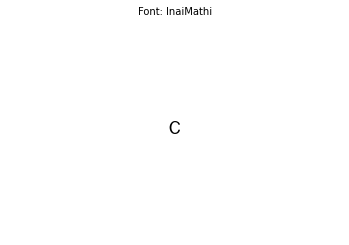

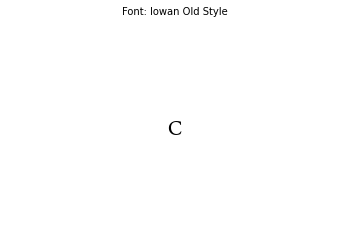

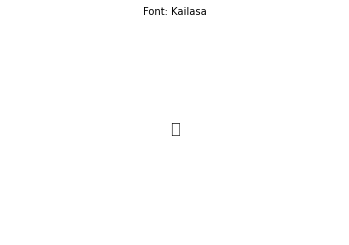

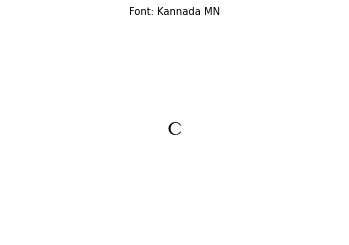

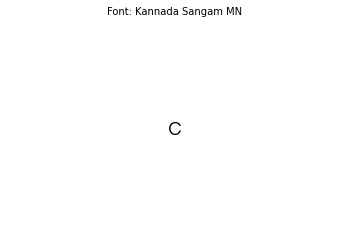

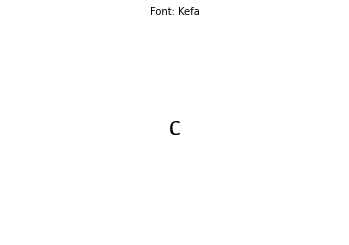

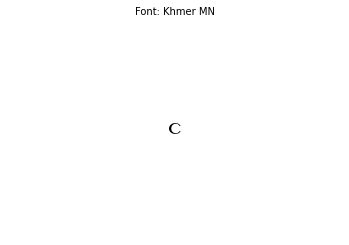

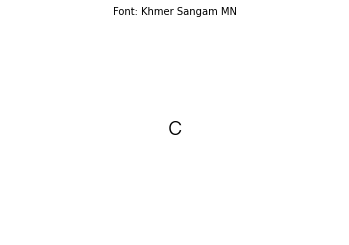

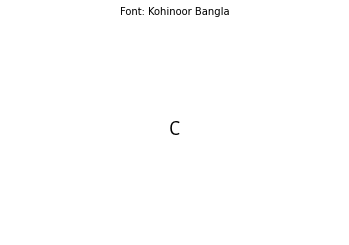

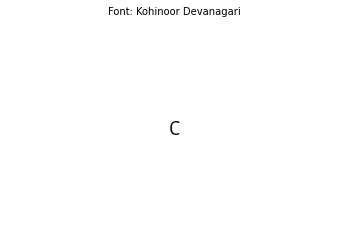

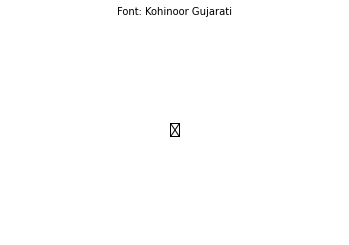

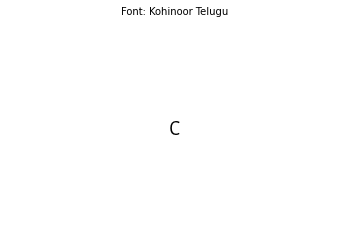

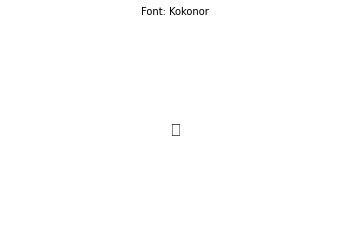

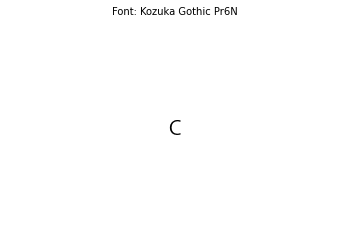

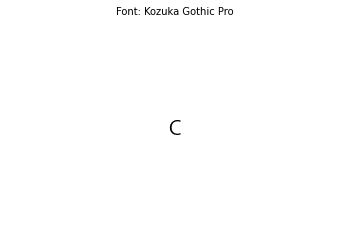

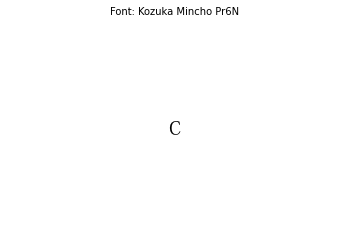

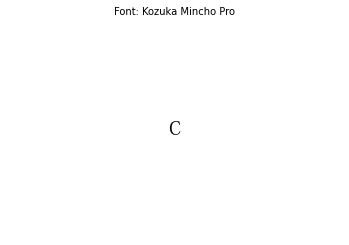

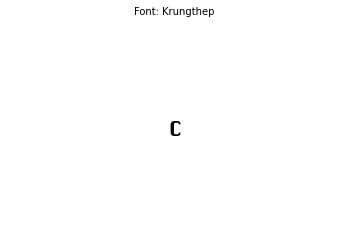

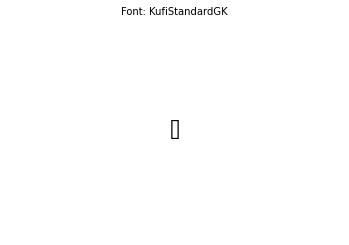

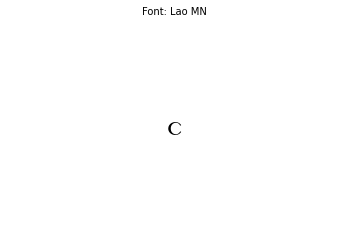

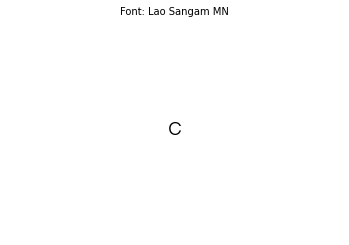

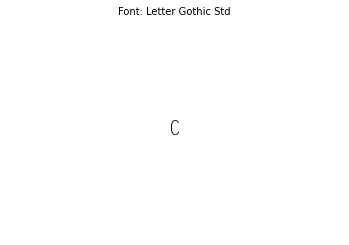

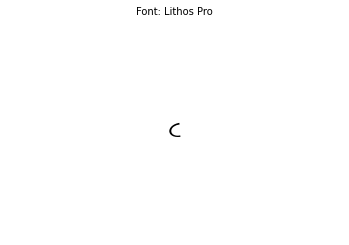

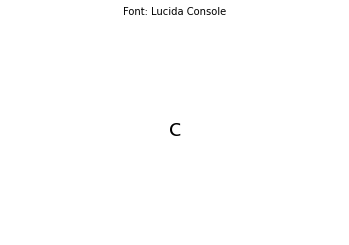

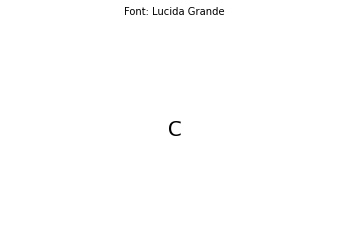

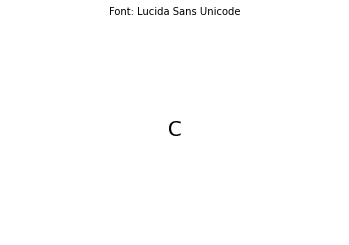

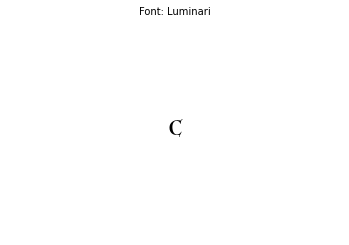

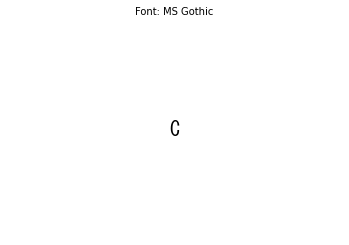

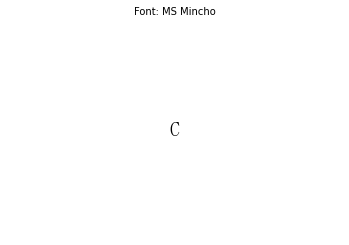

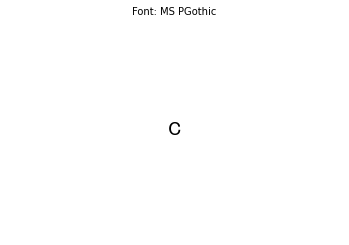

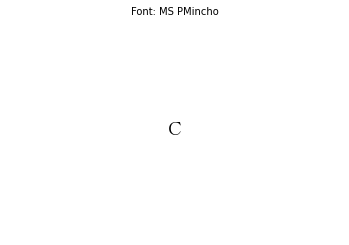

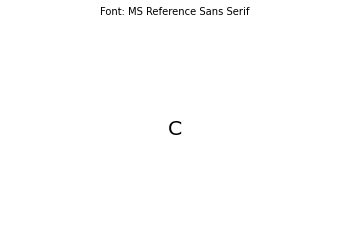

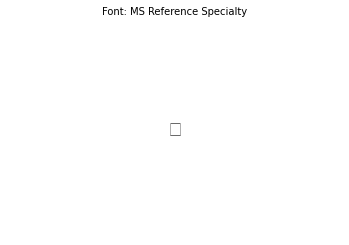

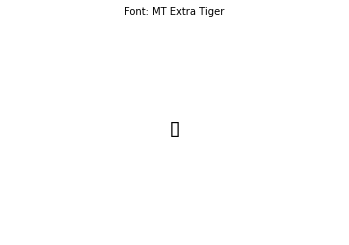

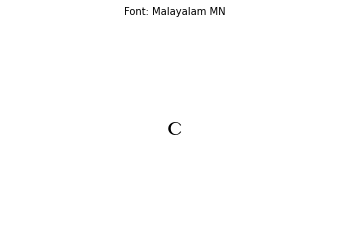

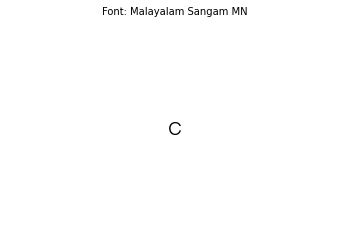

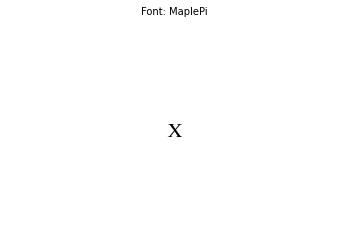

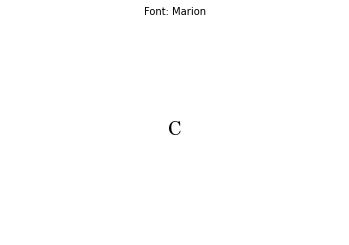

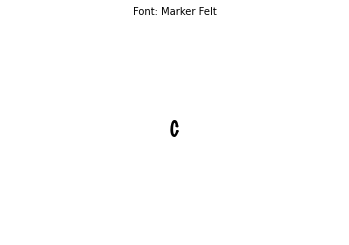

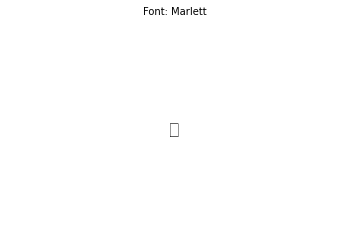

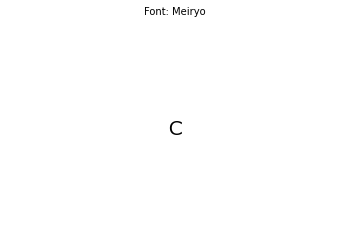

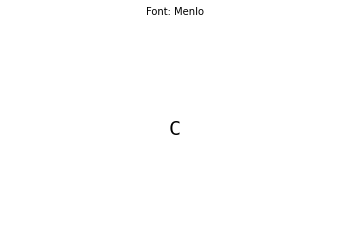

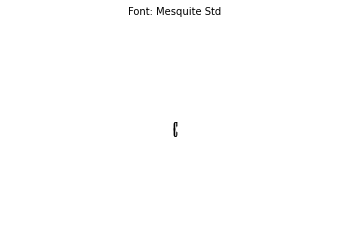

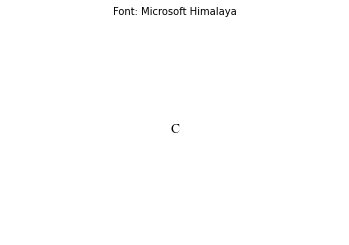

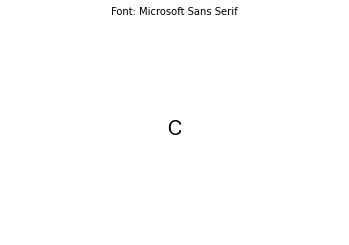

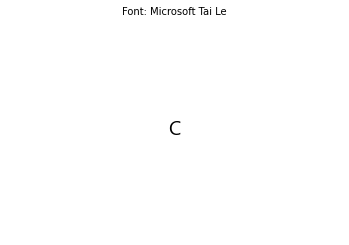

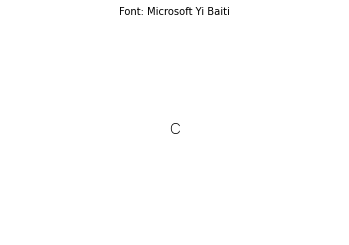

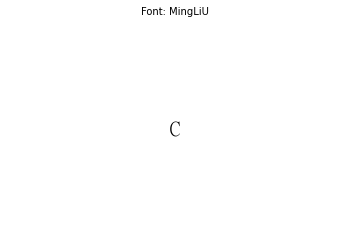

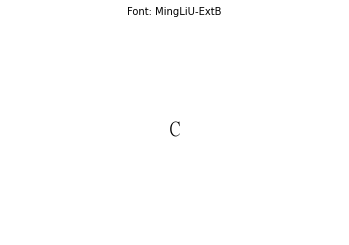

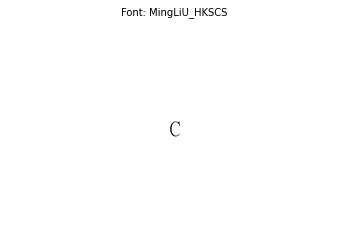

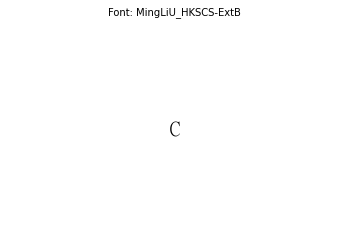

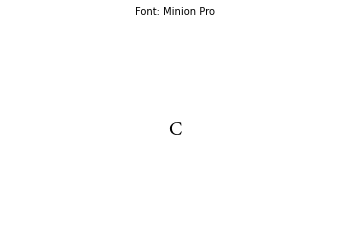

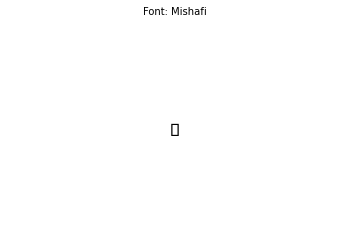

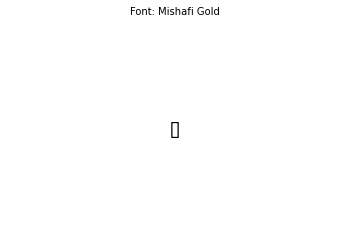

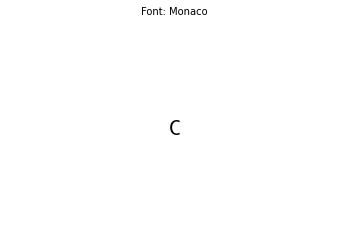

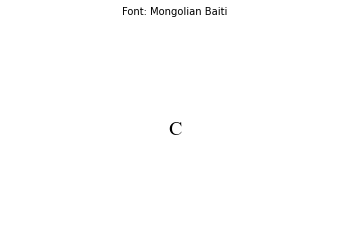

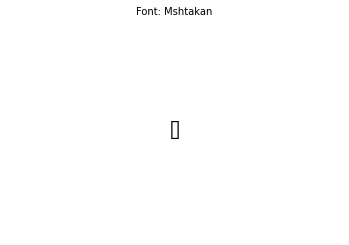

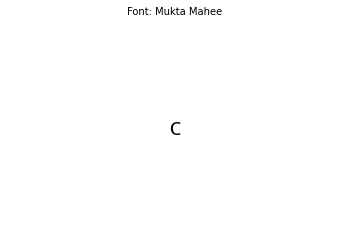

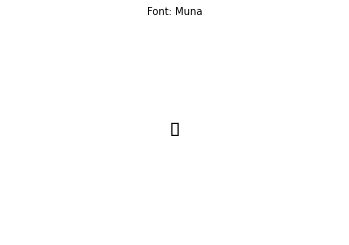

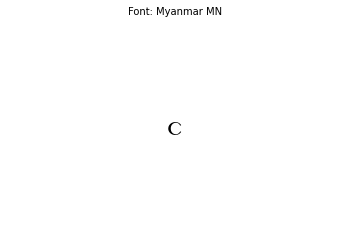

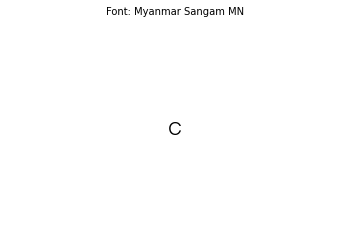

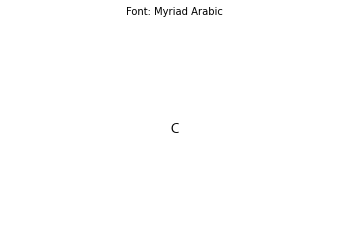

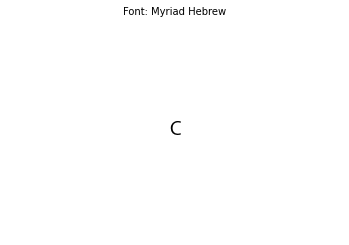

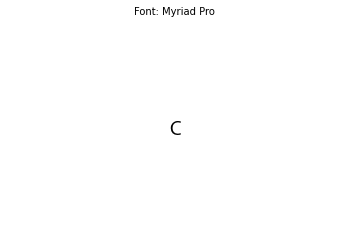

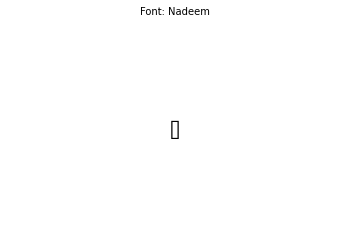

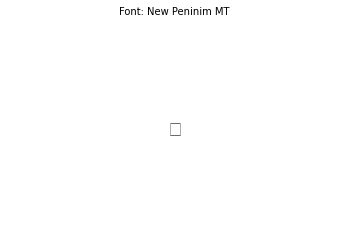

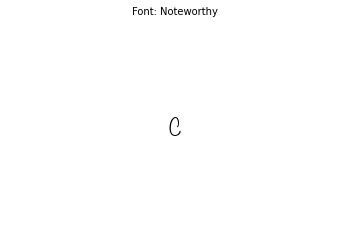

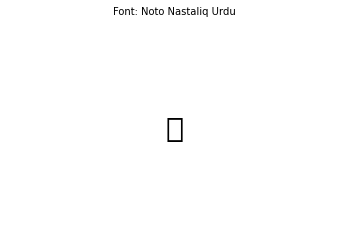

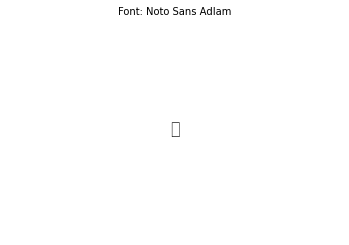

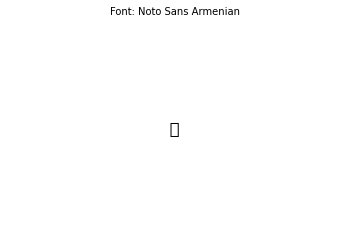

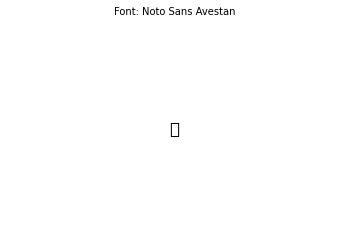

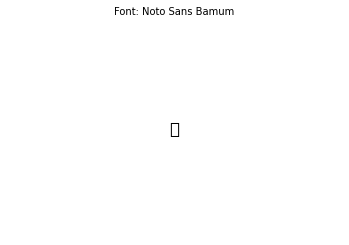

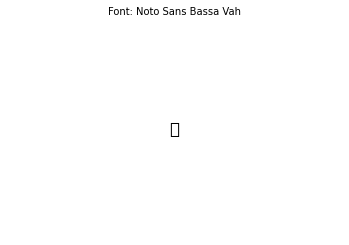

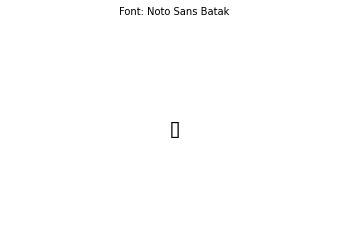

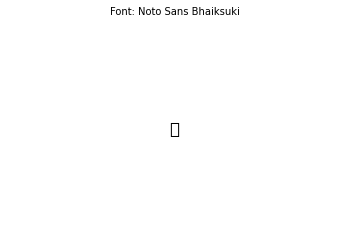

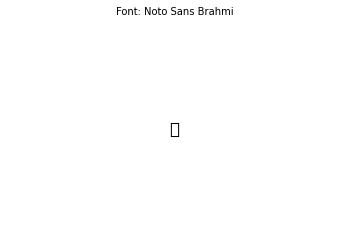

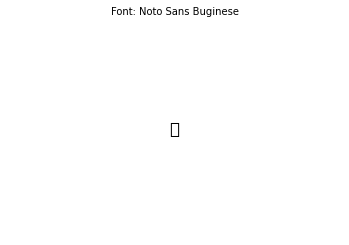

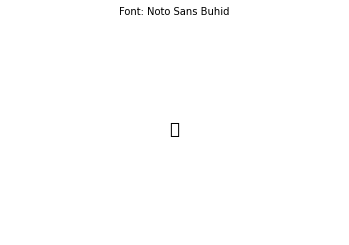

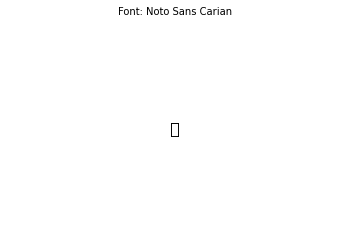

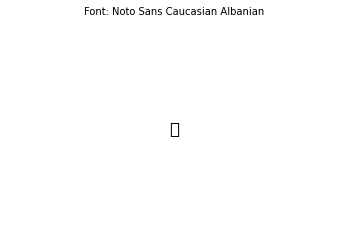

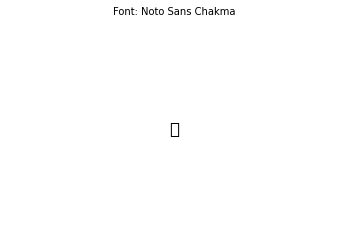

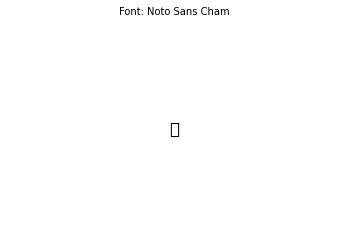

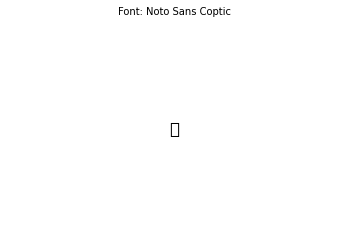

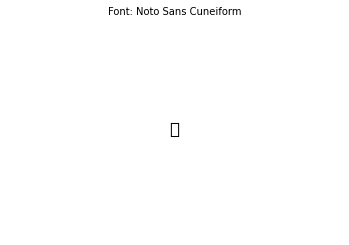

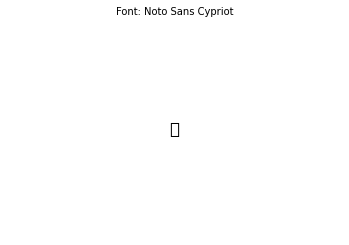

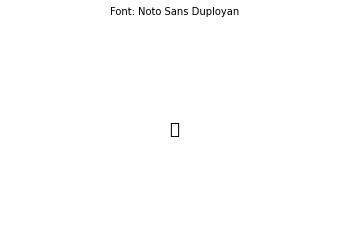

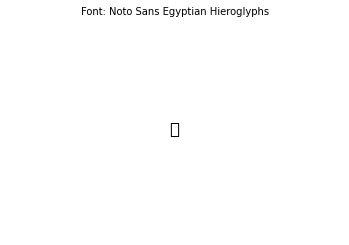

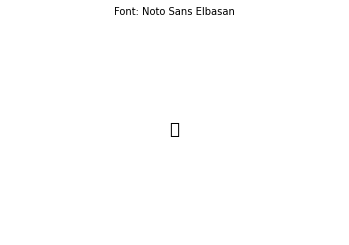

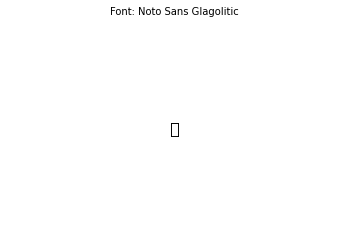

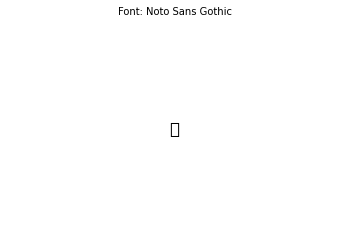

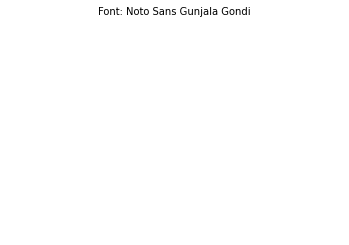

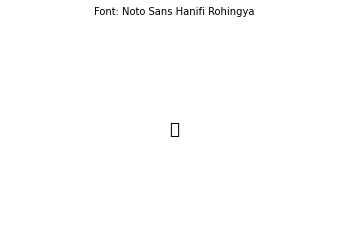

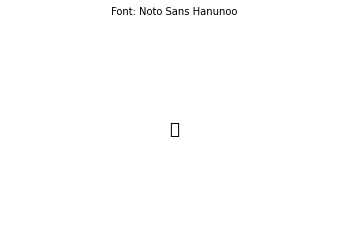

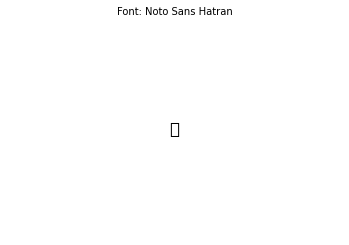

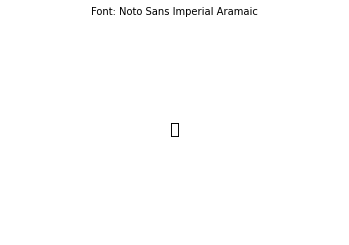

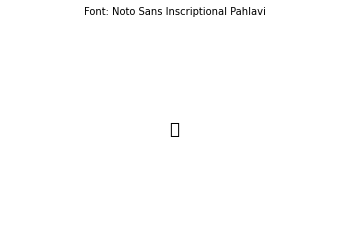

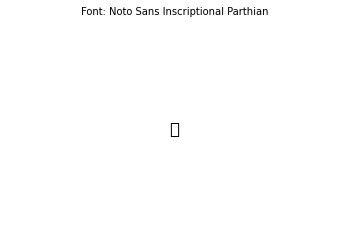

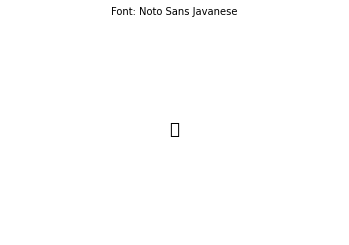

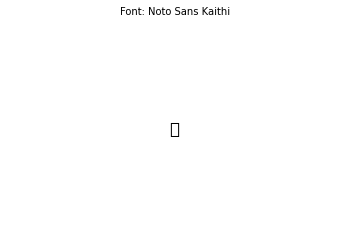

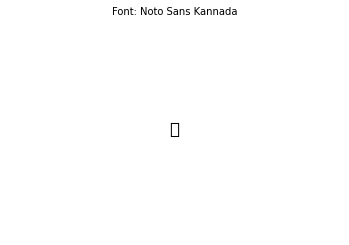

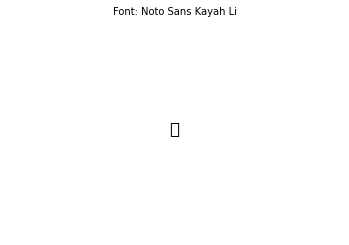

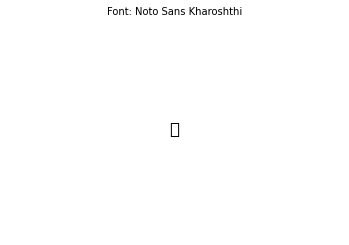

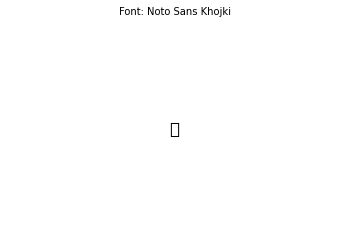

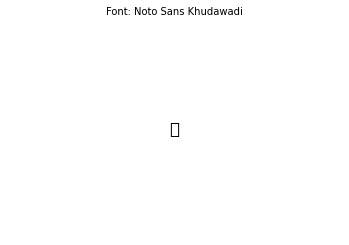

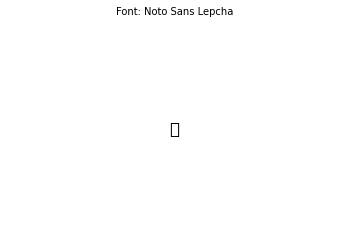

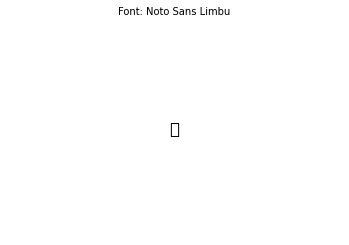

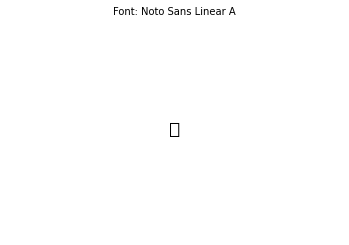

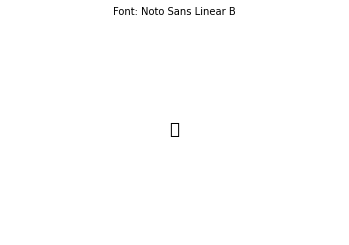

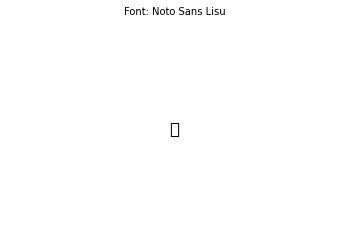

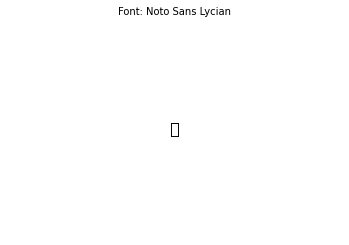

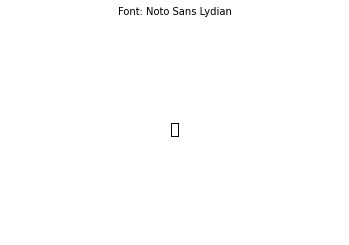

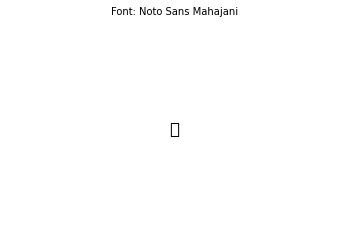

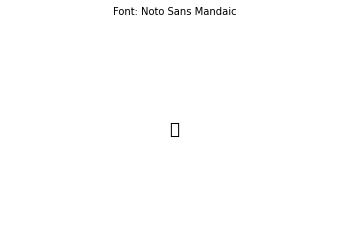

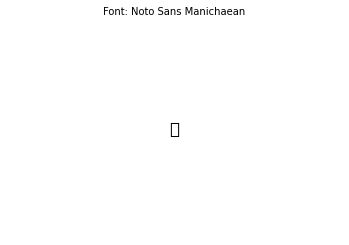

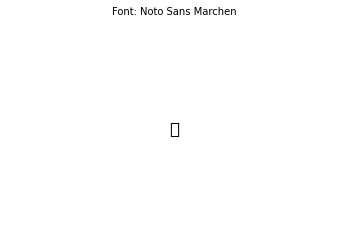

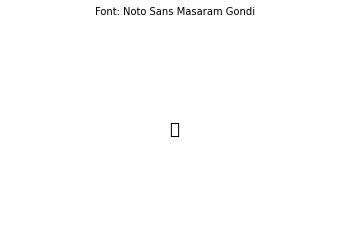

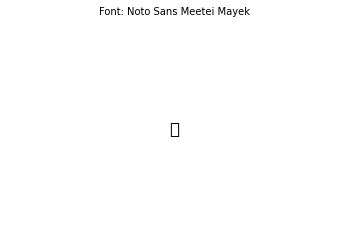

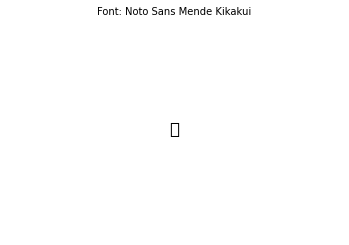

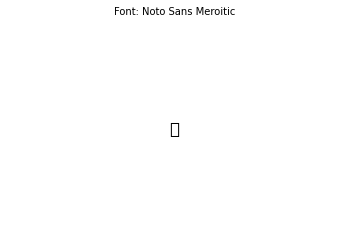

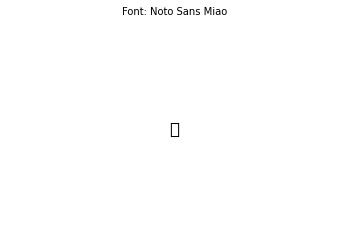

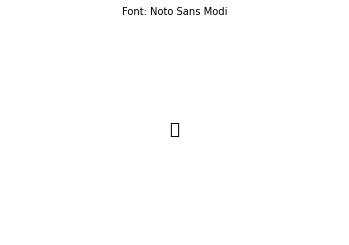

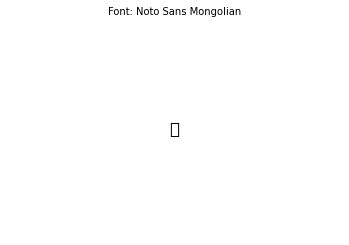

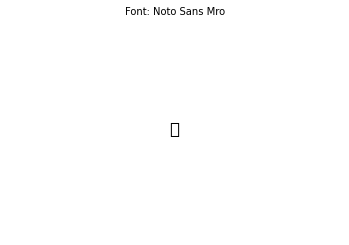

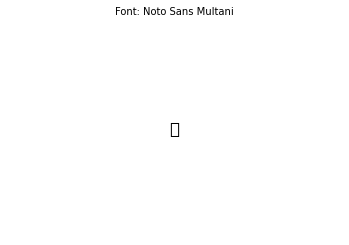

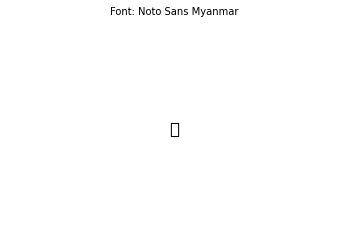

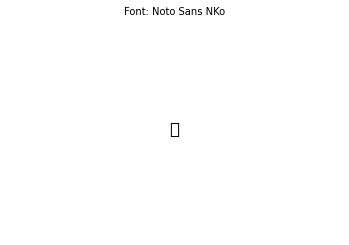

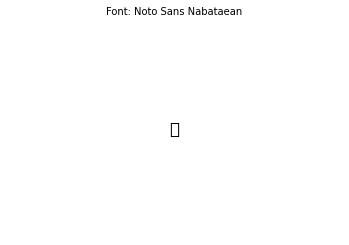

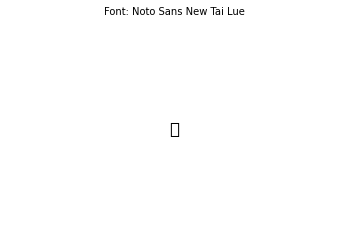

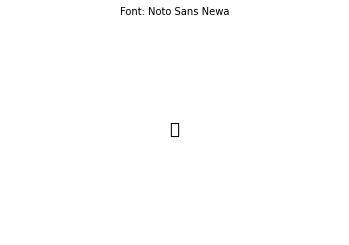

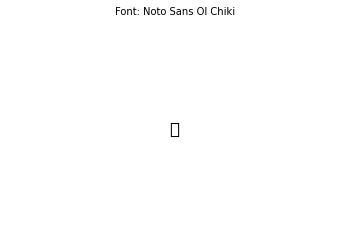

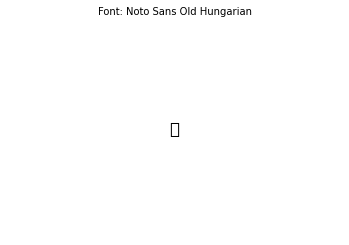

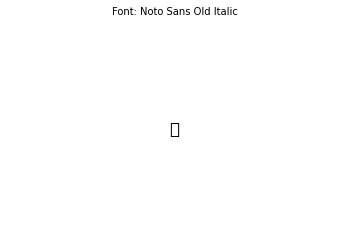

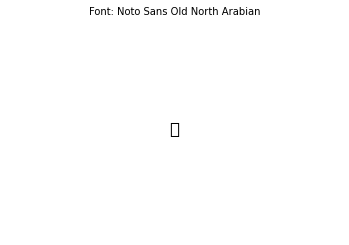

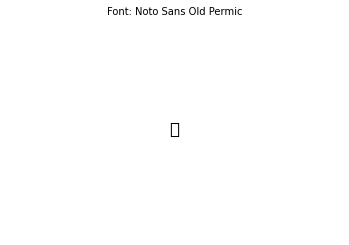

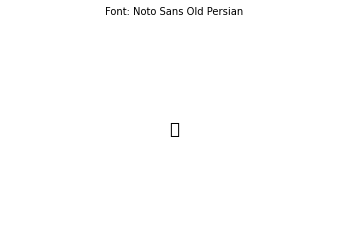

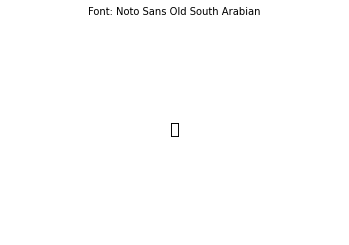

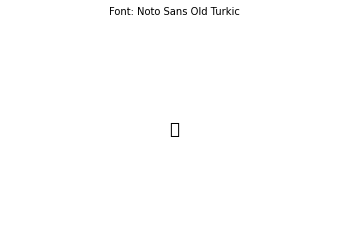

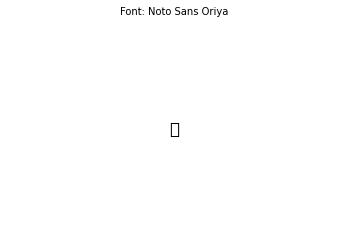

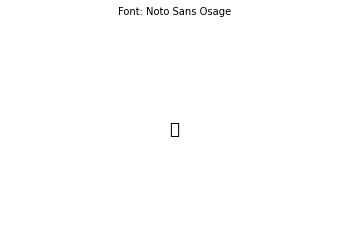

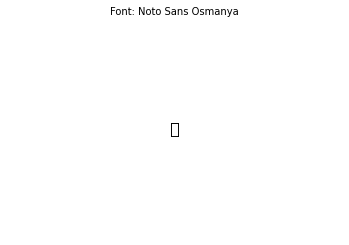

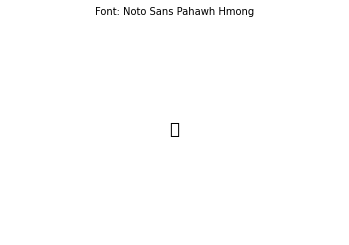

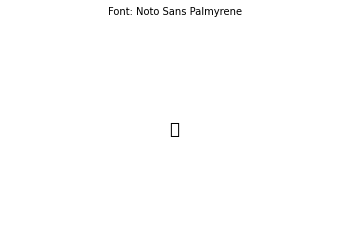

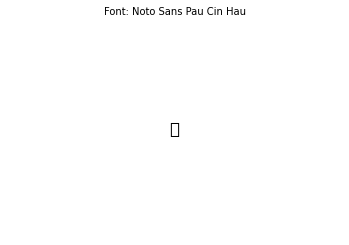

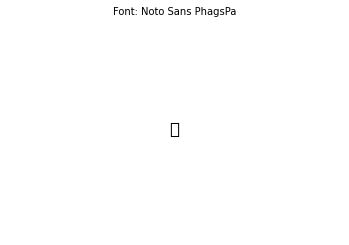

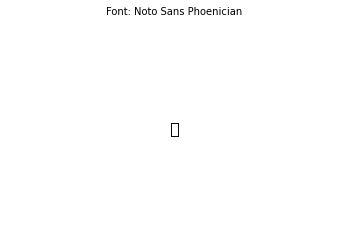

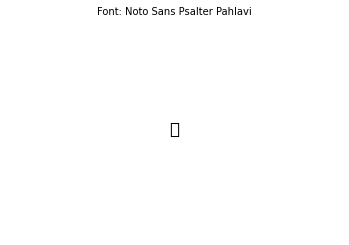

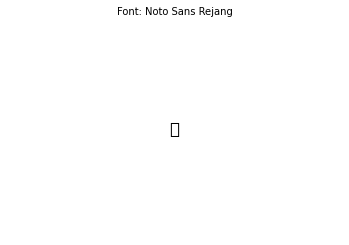

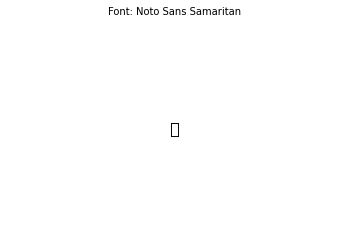

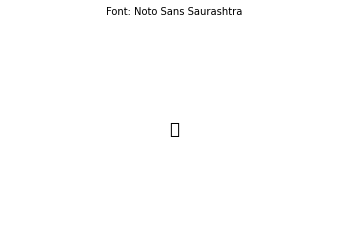

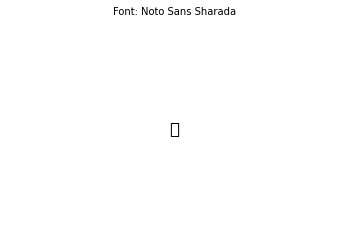

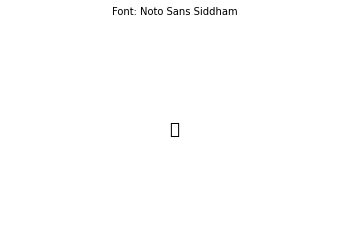

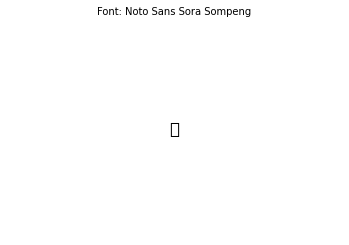

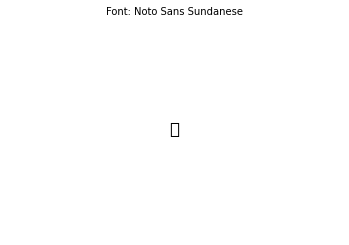

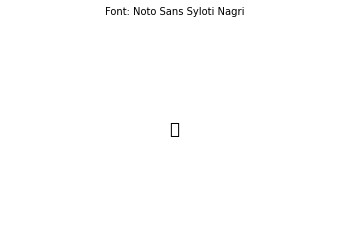

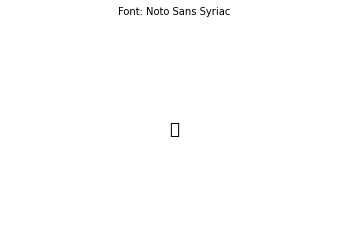

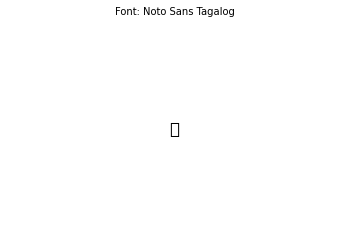

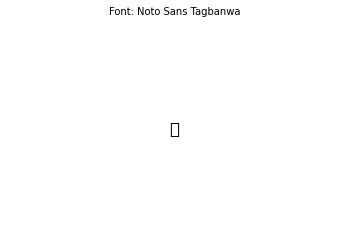

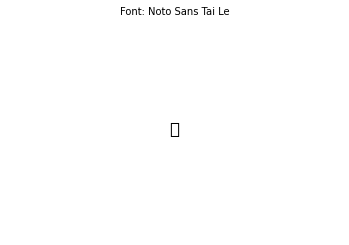

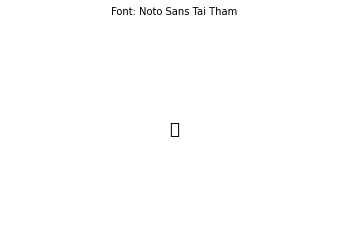

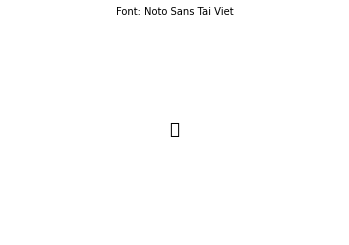

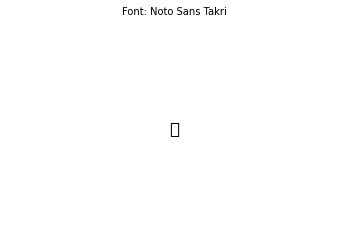

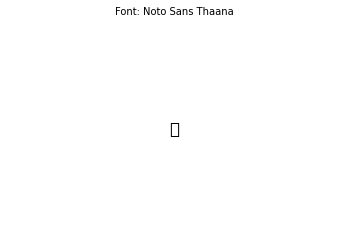

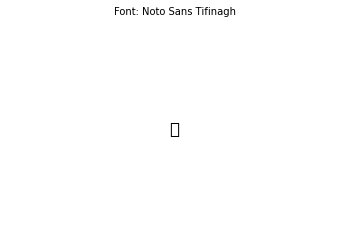

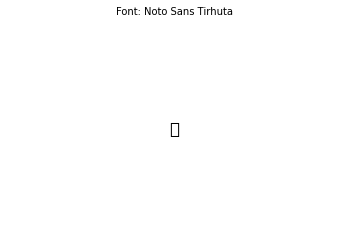

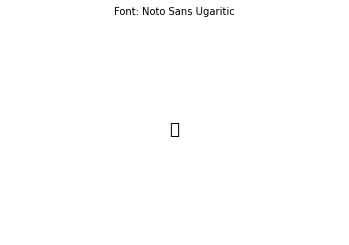

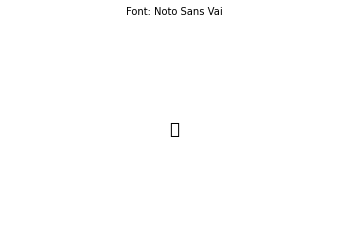

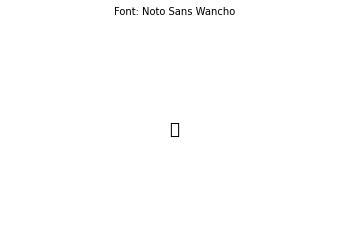

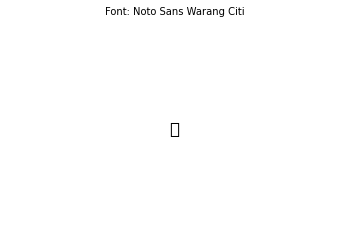

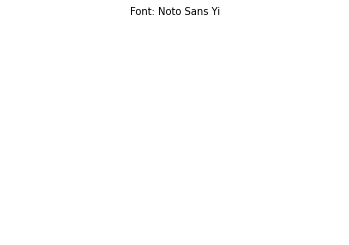

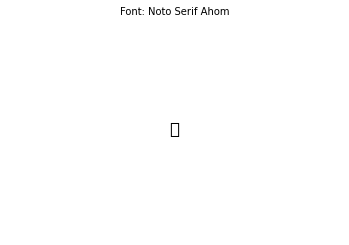

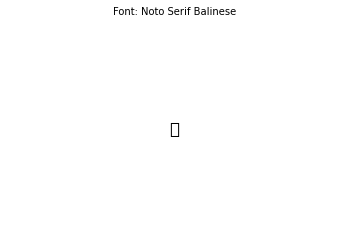

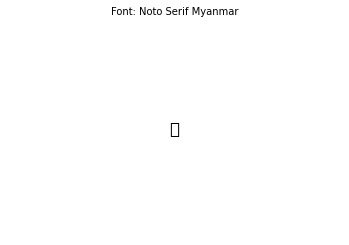

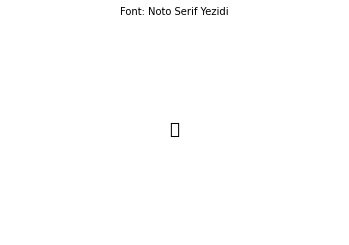

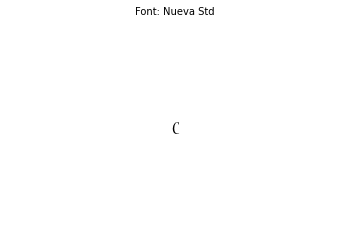

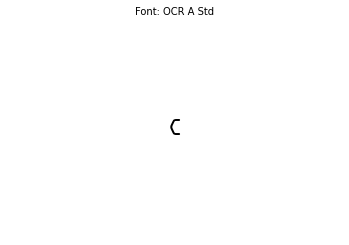

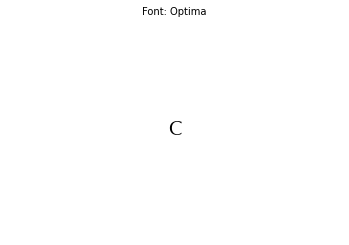

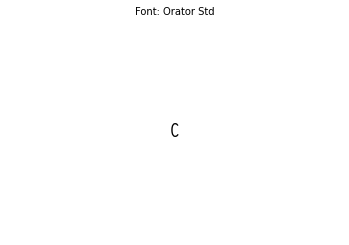

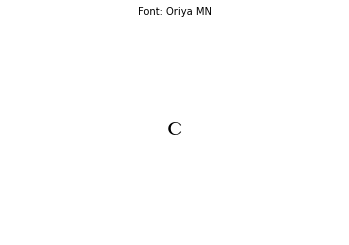

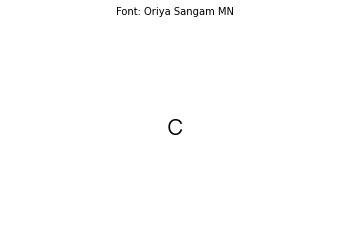

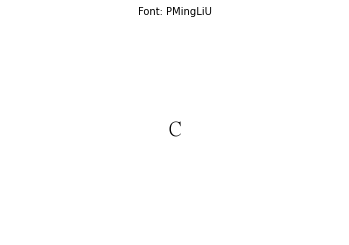

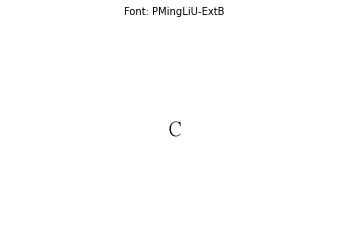

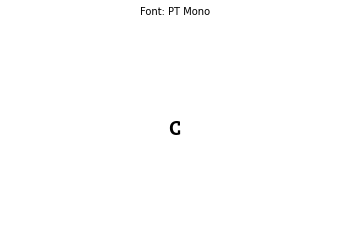

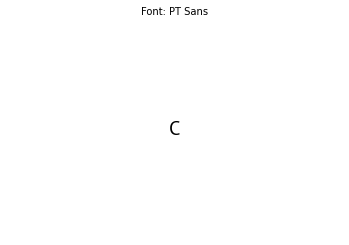

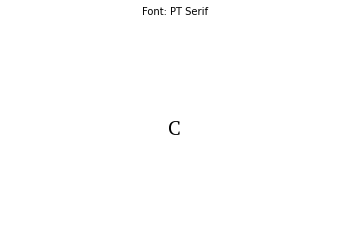

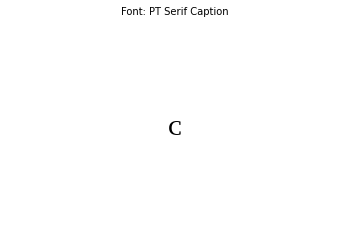

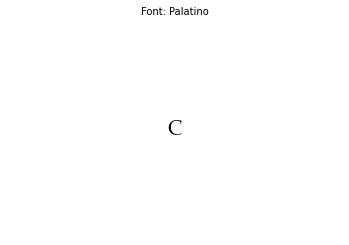

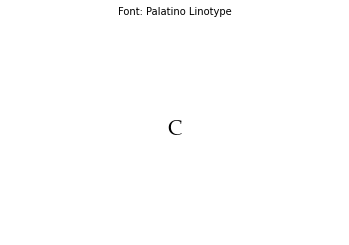

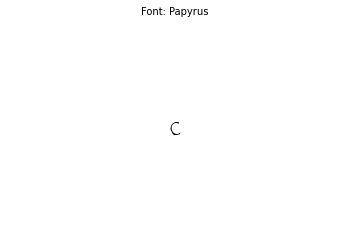

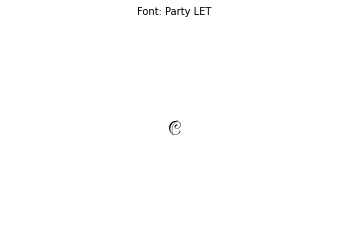

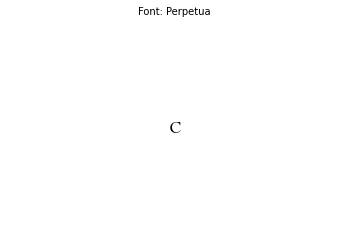

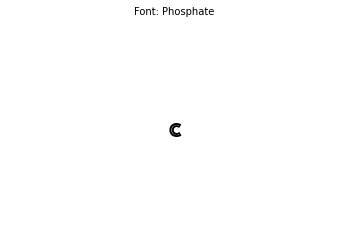

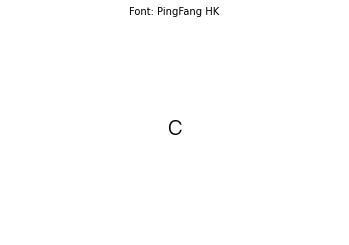

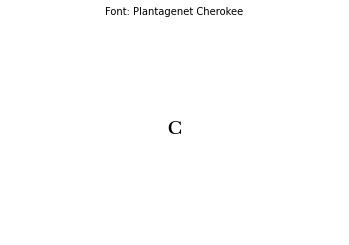

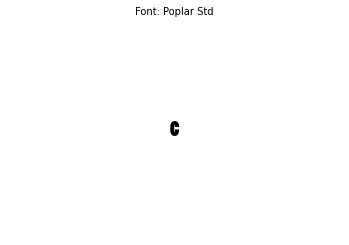

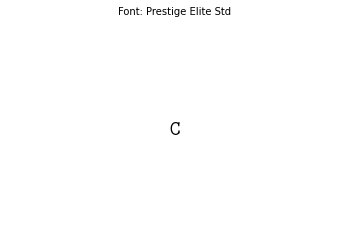

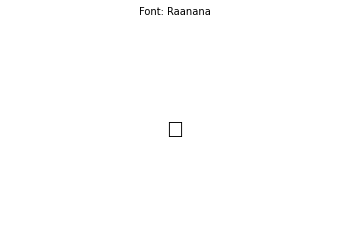

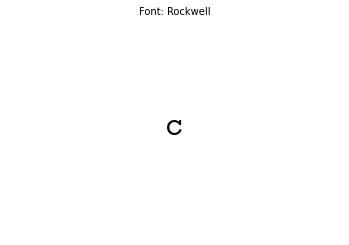

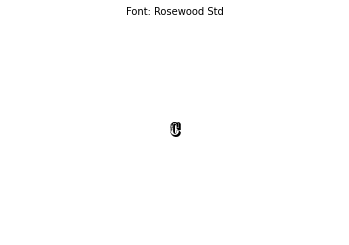

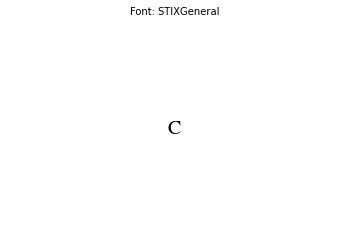

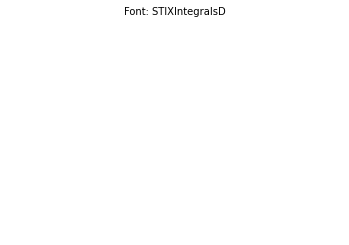

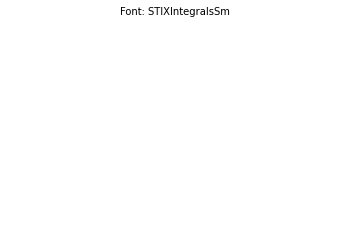

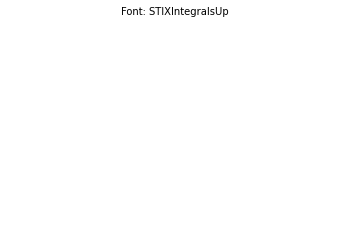

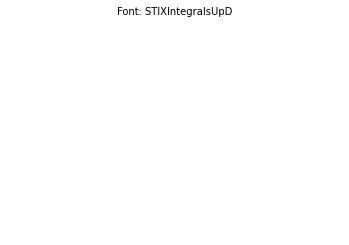

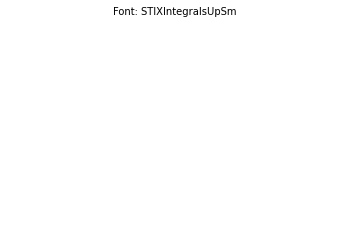

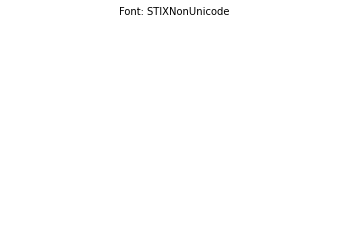

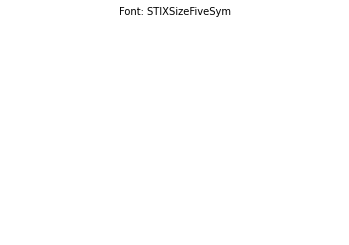

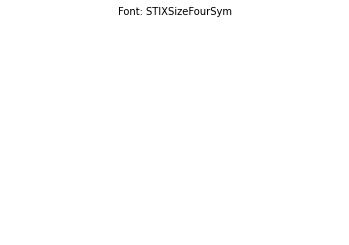

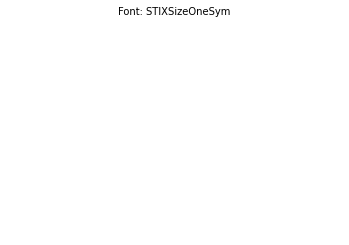

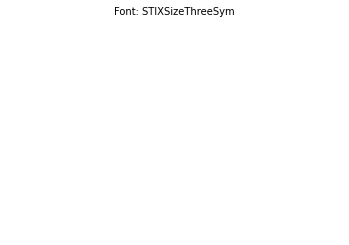

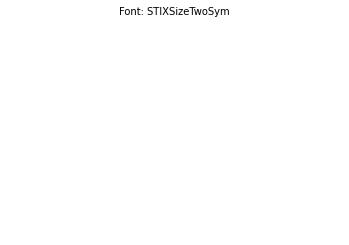

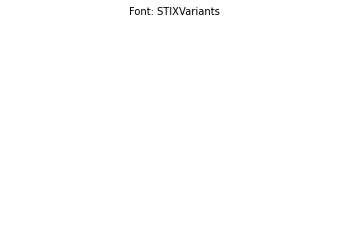

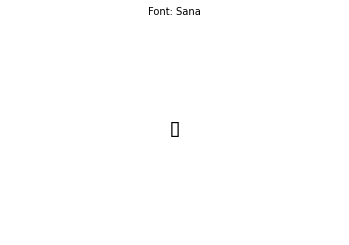

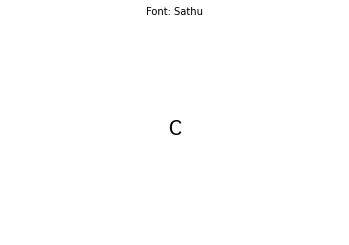

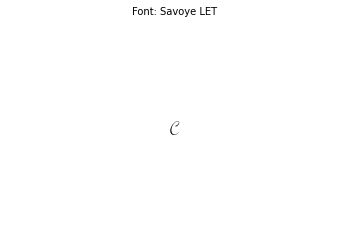

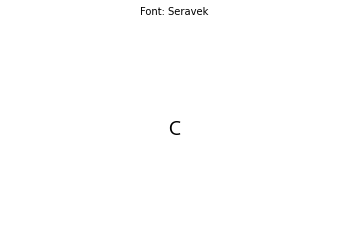

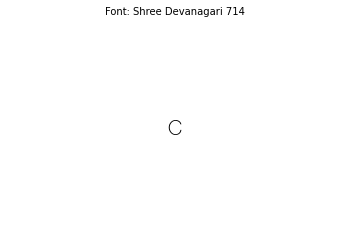

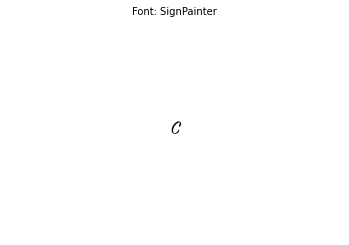

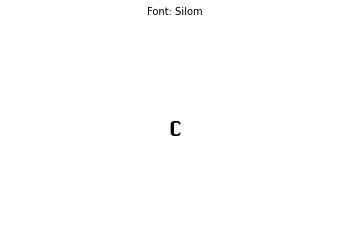

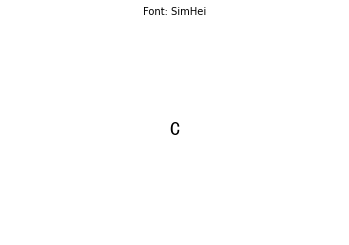

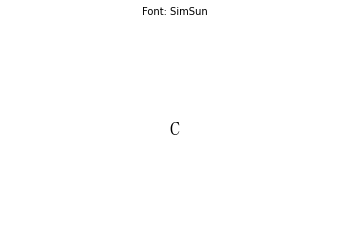

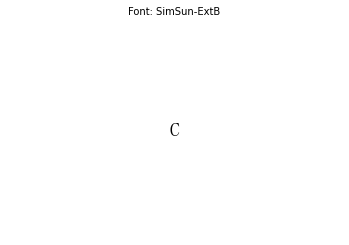

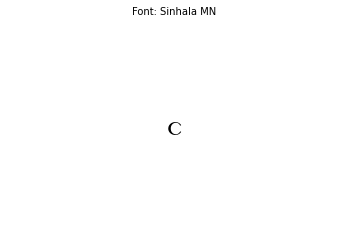

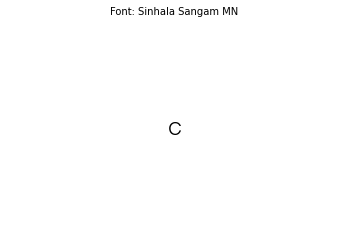

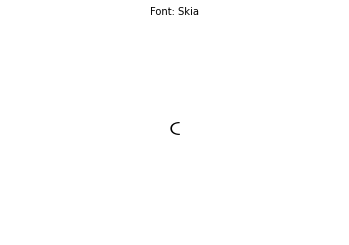

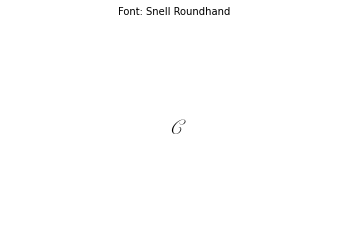

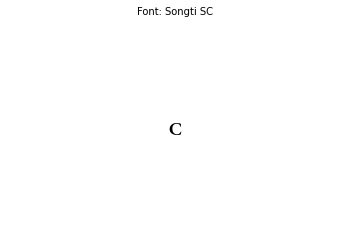

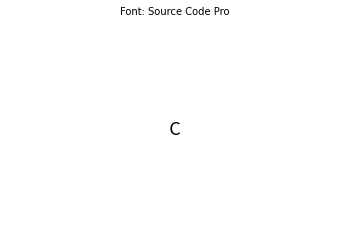

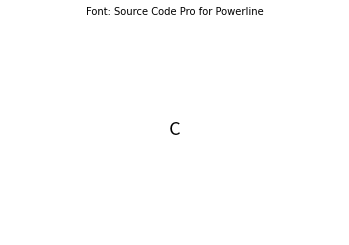

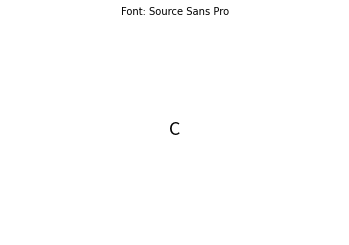

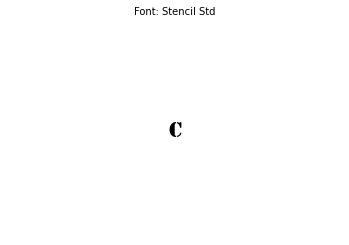

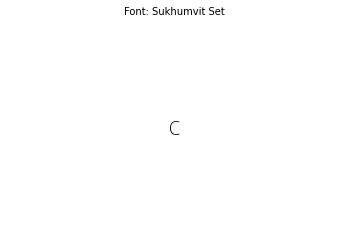

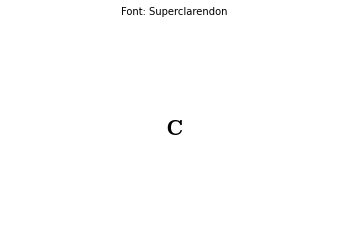

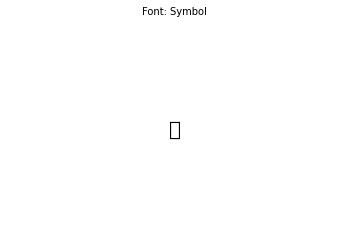

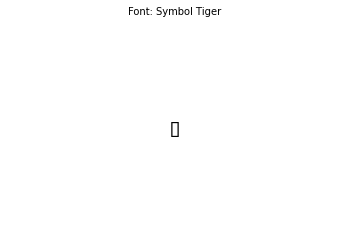

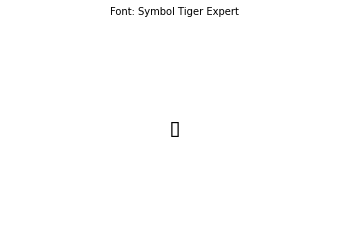

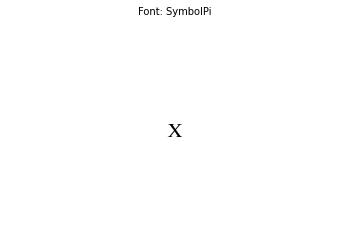

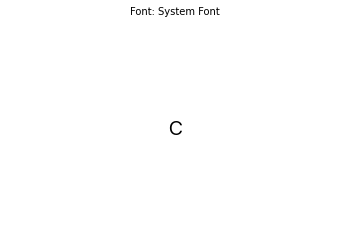

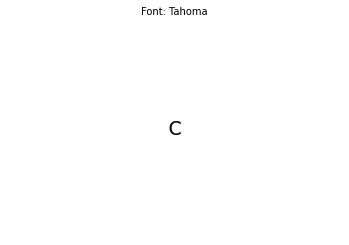

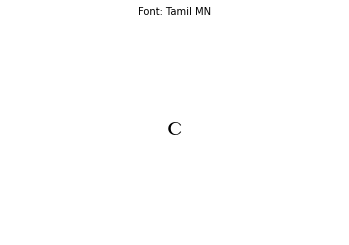

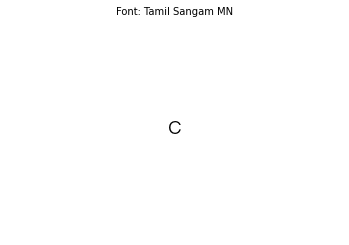

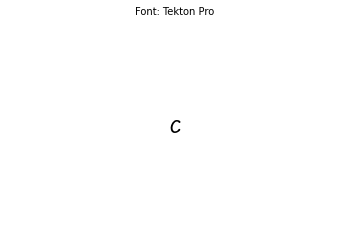

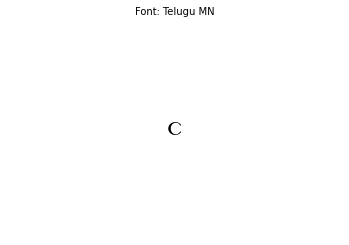

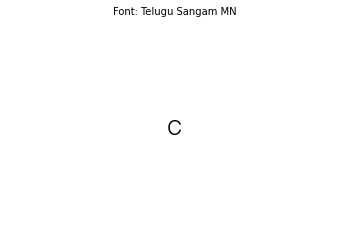

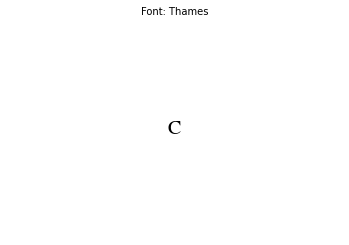

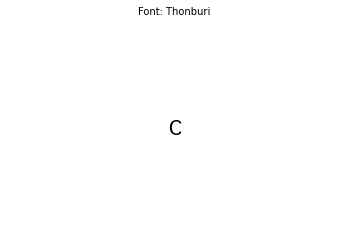

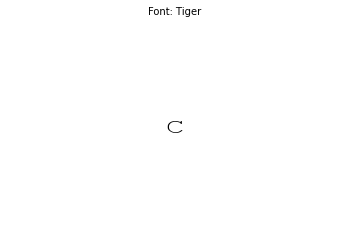

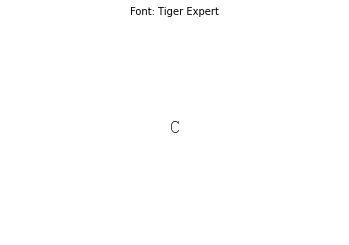

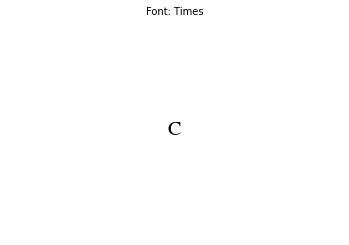

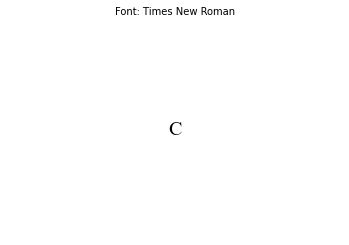

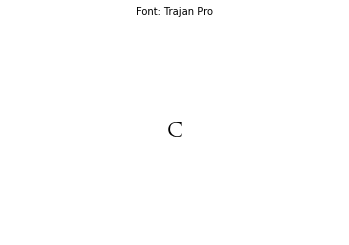

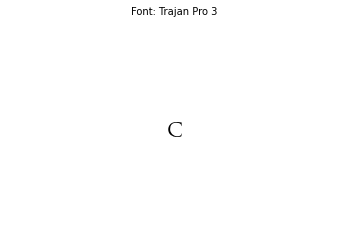

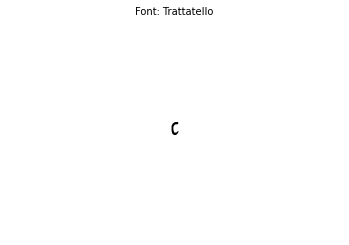

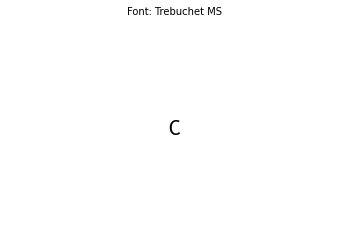

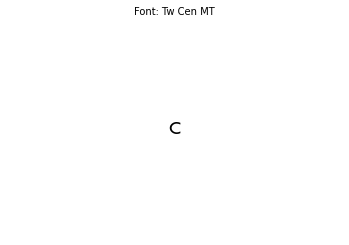

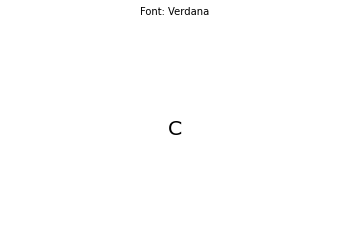

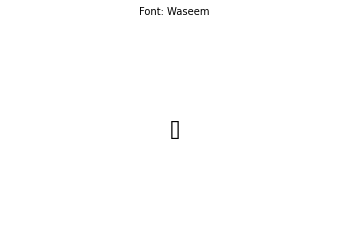

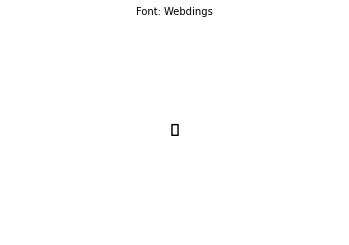

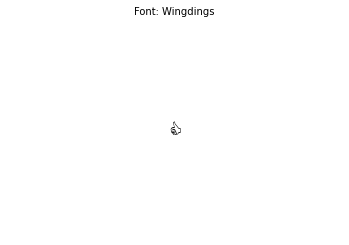

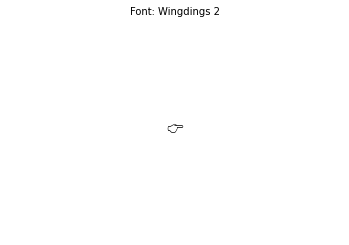

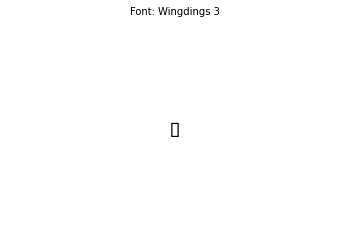

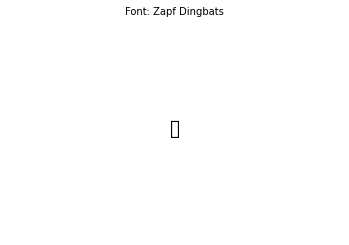

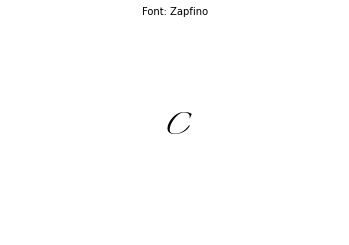

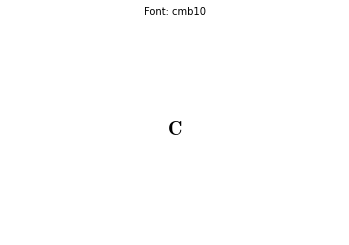

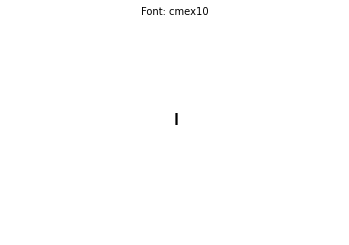

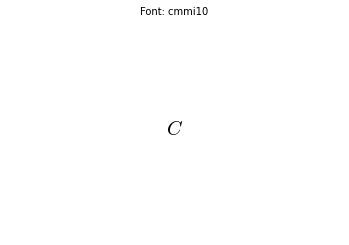

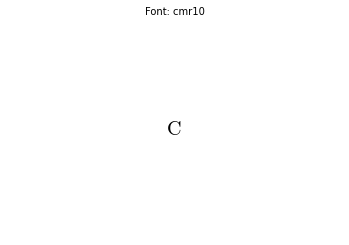

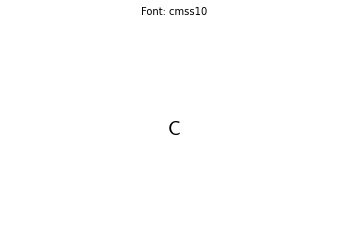

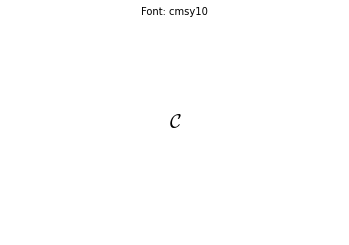

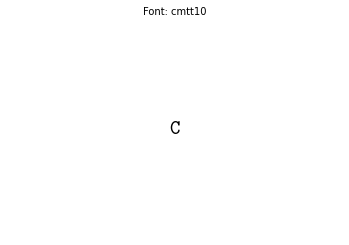

In [231]:
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as font_manager

# # Get a list of unique font family names
# font_families = sorted({f.name for f in font_manager.fontManager.ttflist})

# # Plot the text "C" with each font family
# for font in font_families:
#     fig, ax = plt.subplots()
#     ax.text(0.5, 0.5, 'C', fontfamily=font, fontsize=20, ha='center', va='center')
#     ax.set_title(f"Font: {font}", fontsize=10)
#     ax.axis('off')
#     plt.show()


In [232]:
# #Source from: https://www.businessinsider.com/most-popular-music-artist-by-state-according-to-pandora-2017-7#michigan-drake-22

# State,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10
# Alabama,Kevin Gates,Future,Drake,Beyoncé,Migos,Rihanna,Kodak Black,Bruno Mars,Chris Stapleton,Lil Wayne
# Alaska,Eminem,Drake,Ed Sheeran,Bruno Mars,Adele,Beyoncé,G-Eazy,Rihanna,Twenty One Pilots,Kevin Gates
# Arizona,Drake,Bruno Mars,The Weeknd,Beyoncé,Rihanna,Eminem,Adele,J. Cole,Kendrick Lamar,Future
# Arkansas,Kevin Gates,Drake,Beyoncé,Bruno Mars,Future,Rihanna,Eminem,Chris Stapleton,Migos,Lil Wayne
# California,Drake,Bruno Mars,Beyoncé,Rihanna,Banda Sinaloense MS de Sergio Lizarraga,The Weeknd,2Pac (Tupac),Adele,YG,Kendrick Lamar
# Colorado,Drake,Bruno Mars,Eminem,Kevin Gates,Adele,The Weeknd,Rihanna,Ed Sheeran,Beyoncé,Twenty One Pilots
# Connecticut,Drake,Beyoncé,Rihanna,Eminem,Bruno Mars,Future,Chris Brown,Ozuna,A Boogie Wit Da Hoodie,Adele
# Delaware,Drake,Beyoncé,Future,PnB Rock,Rihanna,Chris Brown,Eminem,A Boogie Wit Da Hoodie,Bruno Mars,Nicki Minaj
# Florida,Drake,Kodak Black,Future,Kevin Gates,Beyoncé,Bruno Mars,Rihanna,Adele,Eminem,The Weeknd
# Georgia,Future,Drake,Beyoncé,Migos,Rihanna,Kevin Gates,Chris Brown,Bruno Mars,YFN Lucci,Kodak Black
# Hawaii,Bruno Mars,Drake,Beyoncé,Rihanna,Common Kings,Bob Marley,Adele,The Green,J Boog,Jack Johnson
# Idaho,Eminem,Drake,Ed Sheeran,Adele,Taylor Swift,Bruno Mars,G-Eazy,Imagine Dragons,Twenty One Pilots,Five Finger Death Punch
# Illinois,Drake,Beyoncé,Future,Rihanna,Bruno Mars,Eminem,Adele,The Weeknd,Chris Brown,Banda Sinaloense MS de Sergio Lizarraga
# Indiana,Drake,Kevin Gates,Eminem,Bruno Mars,Beyoncé,Rihanna,Future,Lil Wayne,Florida Georgia Line,Ed Sheeran
# Iowa,Drake,Eminem,Kevin Gates,Florida Georgia Line,Bruno Mars,Beyoncé,Ed Sheeran,Eric Church,Rihanna,Adele
# Kansas,Drake,Eminem,Kevin Gates,Bruno Mars,Beyoncé,Rihanna,Adele,Five Finger Death Punch,Tech N9ne,The Weeknd
# Kentucky,Kevin Gates,Drake,Eminem,Beyoncé,Chris Stapleton,Future,Bruno Mars,Rihanna,Lil Wayne,Florida Georgia Line
# Louisiana,Kevin Gates,Drake,Beyoncé,Future,Lil Boosie,Lil Wayne,Rihanna,Bruno Mars,K. Michelle,Chris Brown
# Maine,Eminem,Drake,Adele,Ed Sheeran,Nickelback,Florida Georgia Line,Rihanna,Five Finger Death Punch,Beyoncé,Bruno Mars
# Maryland,Drake,Beyoncé,Rihanna,Future,Chris Brown,Bruno Mars,Migos,Eminem,Nicki Minaj,Adele
# Massachusetts,Drake,Beyoncé,Eminem,Rihanna,Adele,Ed Sheeran,Bruno Mars,Future,Ozuna,Chris Brown
# Michigan,Drake,Eminem,Beyoncé,Future,Kevin Gates,Bruno Mars,Rihanna,Chris Brown,Adele,Ed Sheeran
# Minnesota,Drake,Eminem,Bruno Mars,Beyoncé,Rihanna,Kevin Gates,Adele,Ed Sheeran,Taylor Swift,G-Eazy
# Mississippi,Kevin Gates,Future,Beyoncé,Drake,Lil Boosie,Moneybagg Yo,Migos,Rihanna,K. Michelle,Chris Stapleton
# Missouri,Drake,Kevin Gates,Beyoncé,Eminem,Bruno Mars,Future,Rihanna,Migos,Adele,Chris Brown
# Montana,Eminem,Adele,Five Finger Death Punch,Ed Sheeran,Nickelback,G-Eazy,AC/DC,Eric Church,Twenty One Pilots,Bruno Mars
# Nebraska,Drake,Kevin Gates,Eminem,Bruno Mars,Eric Church,Beyoncé,Rihanna,Florida Georgia Line,Adele,Taylor Swift
# Nevada,Drake,Bruno Mars,Eminem,Beyoncé,Rihanna,The Weeknd,Kendrick Lamar,J. Cole,Banda Sinaloense MS de Sergio Lizarraga,2Pac (Tupac)
# New Hampshire,Eminem,Drake,Ed Sheeran,Adele,Zac Brown Band,Florida Georgia Line,Bruno Mars,Rihanna,Taylor Swift,Luke Bryan
# New Jersey,Drake,Beyoncé,Rihanna,Bruno Mars,Future,Eminem,Chris Brown,Adele,Ozuna,Ed Sheeran
# New Mexico,Drake,Bruno Mars,Kevin Gates,Eminem,The Weeknd,Luke Bryan,George Strait,Rihanna,Beyoncé,J. Cole
# New York,Drake,Beyoncé,Rihanna,Eminem,Bruno Mars,Chris Brown,Adele,Future,A Boogie Wit Da Hoodie,Ed Sheeran
# North Carolina,Drake,Beyoncé,Future,Rihanna,Bruno Mars,Migos,Kevin Gates,Chris Brown,Kodak Black,Eminem
# North Dakota,Eminem,Drake,Ed Sheeran,Five Finger Death Punch,Florida Georgia Line,Nickelback,G-Eazy,Bruno Mars,Eric Church,AC/DC
# Ohio,Drake,Eminem,Kevin Gates,Future,Beyoncé,Bruno Mars,Rihanna,Chris Brown,Migos,Lil Wayne
# Oklahoma,Drake,Kevin Gates,Eminem,Bruno Mars,Beyoncé,Rihanna,Adele,Migos,The Weeknd,Chris Stapleton
# Oregon,Drake,Eminem,Bruno Mars,Adele,Rihanna,Beyoncé,Ed Sheeran,The Weeknd,G-Eazy,Kendrick Lamar
# Pennsylvania,Drake,Beyoncé,Eminem,Rihanna,Future,Bruno Mars,Chris Brown,Nicki Minaj,PnB Rock,Ed Sheeran
# Rhode Island,Drake,Beyoncé,Eminem,Rihanna,A Boogie Wit Da Hoodie,Future,Bruno Mars,Adele,Ed Sheeran,Ozuna
# South Carolina,Kevin Gates,Drake,Future,Beyoncé,Migos,Kodak Black,Rihanna,Bruno Mars,Chris Brown,Eminem
# South Dakota,Eminem,Drake,Florida Georgia Line,Kevin Gates,G-Eazy,Eric Church,Five Finger Death Punch,Ed Sheeran,Taylor Swift,Rihanna
# Tennessee,Kevin Gates,Drake,Beyoncé,Future,Bruno Mars,Rihanna,Migos,Eminem,Chris Brown,Chris Stapleton
# Texas,Drake,Kevin Gates,Beyoncé,Future,Bruno Mars,Rihanna,The Weeknd,George Strait,Luke Bryan,Migos
# Utah,Eminem,Imagine Dragons,Taylor Swift,Bruno Mars,Twenty One Pilots,Drake,Ed Sheeran,Adele,Meghan Trainor,G-Eazy
# Vermont,Eminem,Drake,Nickelback,Adele,AC/DC,Ed Sheeran,Five Finger Death Punch,Florida Georgia Line,Bob Marley,Rihanna
# Virginia,Drake,Beyoncé,Future,Rihanna,Bruno Mars,Chris Brown,Eminem,Migos,Kevin Gates,Adele
# Washington,Drake,Bruno Mars,Eminem,Adele,Beyoncé,Rihanna,The Weeknd,Ed Sheeran,Kendrick Lamar,Taylor Swift
# West Virginia,Drake,Kevin Gates,Eminem,Florida Georgia Line,Beyoncé,Five Finger Death Punch,Nickelback,Rihanna,Lil Wayne,Fetty Wap
# Wisconsin,Drake,Eminem,Beyoncé,Future,Bruno Mars,Kevin Gates,Ed Sheeran,Adele,Rihanna,Five Finger Death Punch
# Wyoming,Eminem,G-Eazy,Five Finger Death Punch,Drake,Nickelback,Ed Sheeran,Adele,Bruno Mars,Luke Bryan,Tech N9ne



SyntaxError: invalid syntax (2885154121.py, line 4)

In [ ]:
# # Data
# data = {
#     'State': ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
#     'Top1': ['Kevin Gates', 'Eminem', 'Drake', 'Kevin Gates', 'Drake', 'Drake', 'Drake', 'Drake', 'Drake', 'Future', 'Bruno Mars', 'Eminem', 'Drake', 'Drake', 'Drake', 'Drake', 'Kevin Gates', 'Kevin Gates', 'Eminem', 'Drake', 'Drake', 'Drake', 'Drake', 'Kevin Gates', 'Drake', 'Eminem', 'Drake', 'Drake', 'Eminem', 'Drake', 'Drake', 'Drake', 'Drake', 'Eminem', 'Drake', 'Drake', 'Drake', 'Drake', 'Drake', 'Kevin Gates', 'Eminem', 'Kevin Gates', 'Drake', 'Eminem', 'Eminem', 'Drake', 'Drake', 'Drake', 'Drake', 'Eminem'],
#     'Top2': ['Future', 'Drake', 'Bruno Mars', 'Drake', 'Bruno Mars', 'Bruno Mars', 'Beyoncé', 'Beyoncé', 'Kodak Black', 'Drake', 'Drake', 'Drake', 'Beyoncé', 'Kevin Gates', 'Eminem', 'Eminem', 'Drake', 'Drake', 'Drake', 'Beyoncé', 'Beyoncé', 'Eminem', 'Eminem', 'Future', 'Kevin Gates', 'Adele', 'Kevin Gates', 'Bruno Mars', 'Drake', 'Beyoncé', 'Bruno Mars', 'Beyoncé', 'Beyoncé', 'Drake', 'Eminem', 'Kevin Gates', 'Eminem', 'Beyoncé', 'Beyoncé', 'Drake', 'Drake', 'Drake', 'Kevin Gates', 'Imagine Dragons', 'Drake', 'Beyoncé', 'Bruno Mars', 'Kevin Gates', 'Eminem', 'G-Eazy'],
#     'Top3': ['Drake', 'Ed Sheeran', 'The Weeknd', 'Beyoncé', 'Beyoncé', 'Eminem', 'Rihanna', 'Future', 'Future', 'Beyoncé', 'Beyoncé', 'Ed Sheeran', 'Future', 'Eminem', 'Kevin Gates', 'Kevin Gates', 'Eminem', 'Beyoncé', 'Adele', 'Rihanna', 'Eminem', 'Beyoncé', 'Bruno Mars', 'Beyoncé', 'Beyoncé', 'Five Finger Death Punch', 'Eminem', 'Eminem', 'Ed Sheeran', 'Rihanna', 'Kevin Gates', 'Rihanna', 'Future', 'Ed Sheeran', 'Kevin Gates', 'Eminem', 'Bruno Mars', 'Eminem', 'Eminem', 'Future', 'Florida Georgia Line', 'Beyoncé', 'Beyoncé', 'Taylor Swift', 'Nickelback', 'Future', 'Eminem', 'Eminem', 'Beyoncé', 'Five Finger Death Punch'],
#     'Top4': ['Beyoncé', 'Bruno Mars', 'Beyoncé', 'Bruno Mars', 'Rihanna', 'Adele', 'Eminem', 'PnB Rock', 'Kevin Gates', 'Migos', 'Rihanna', 'Adele', 'Rihanna', 'Bruno Mars', 'Florida Georgia Line', 'Bruno Mars', 'Beyoncé', 'Future', 'Ed Sheeran', 'Future', 'Rihanna', 'Future', 'Beyoncé', 'Drake', 'Eminem', 'Ed Sheeran', 'Bruno Mars', 'Beyoncé', 'Adele', 'Bruno Mars', 'Eminem', 'Eminem', 'Rihanna', 'Five Finger Death Punch', 'Future', 'Bruno Mars', 'Adele', 'Rihanna', 'Rihanna', 'Beyoncé', 'Kevin Gates', 'Future', 'Future', 'Bruno Mars', 'Adele', 'Rihanna', 'Adele', 'Florida Georgia Line', 'Future', 'Five Finger Death Punch'],
#     'Top5': ['Migos', 'Adele', 'Rihanna', 'Future', 'Banda Sinaloense MS de Sergio Lizarraga', 'Kevin Gates', 'Bruno Mars', 'Rihanna', 'Beyoncé', 'Rihanna', 'Common Kings', 'Taylor Swift', 'Bruno Mars', 'Beyoncé', 'Bruno Mars', 'Beyoncé', 'Chris Stapleton', 'Lil Boosie', 'Nickelback', 'Chris Brown', 'Adele', 'Kevin Gates', 'Rihanna', 'Lil Boosie', 'Bruno Mars', 'Nickelback', 'Eric Church', 'Rihanna', 'Zac Brown Band', 'Future', 'The Weeknd', 'Bruno Mars', 'Bruno Mars', 'Florida Georgia Line', 'Beyoncé', 'Beyoncé', 'Rihanna', 'Future', 'A Boogie Wit Da Hoodie', 'Migos', 'G-Eazy', 'Bruno Mars', 'Bruno Mars', 'Twenty One Pilots', 'AC/DC', 'Bruno Mars', 'Beyoncé', 'Beyoncé', 'Bruno Mars', 'Eminem'],
#     'Top6': ['Rihanna', 'Beyoncé', 'Eminem', 'Rihanna', 'The Weeknd', 'Adele', 'Future', 'Chris Brown', 'Bruno Mars', 'Kevin Gates', 'Bob Marley', 'Bruno Mars', 'Eminem', 'Rihanna', 'Beyoncé', 'Rihanna', 'Future', 'Lil Wayne', 'Florida Georgia Line', 'Bruno Mars', 'Ed Sheeran', 'Bruno Mars', 'Kevin Gates', 'Moneybagg Yo', 'Future', 'G-Eazy', 'Beyoncé', 'The Weeknd', 'Florida Georgia Line', 'Eminem', 'Luke Bryan', 'Chris Brown', 'Migos', 'Nickelback', 'Bruno Mars', 'Rihanna', 'Beyoncé', 'Bruno Mars', 'Future', 'Kodak Black', 'Eric Church', 'Rihanna', 'Rihanna', 'Drake', 'Ed Sheeran', 'Chris Brown', 'Rihanna', 'Nickelback', 'Kevin Gates', 'Nickelback'],
#     'Top7': ['Kodak Black', 'G-Eazy', 'Adele', 'Eminem', '2Pac (Tupac)', 'The Weeknd', 'Chris Brown', 'Eminem', 'Adele', 'Chris Brown', 'Adele', 'G-Eazy', 'Adele', 'Future', 'Ed Sheeran', 'Adele', 'Bruno Mars', 'Rihanna', 'Rihanna', 'Migos', 'Bruno Mars', 'Rihanna', 'Adele', 'Migos', 'Rihanna', 'AC/DC', 'Rihanna', 'Kendrick Lamar', 'Bruno Mars', 'Chris Brown', 'George Strait', 'Adele', 'Kevin Gates', 'G-Eazy', 'Chris Brown', 'Adele', 'Ed Sheeran', 'Chris Brown', 'Bruno Mars', 'Bruno Mars', 'Five Finger Death Punch', 'Migos', 'The Weeknd', 'Ed Sheeran', 'Five Finger Death Punch', 'Eminem', 'The Weeknd', 'Rihanna', 'Ed Sheeran', 'Ed Sheeran'],
#     'Top8': ['Bruno Mars', 'Rihanna', 'J. Cole', 'Chris Stapleton', 'Adele', 'Ed Sheeran', 'Ozuna', 'A Boogie Wit Da Hoodie', 'Eminem', 'Bruno Mars', 'The Green', 'Imagine Dragons', 'The Weeknd', 'Lil Wayne', 'Eric Church', 'Five Finger Death Punch', 'Rihanna', 'Bruno Mars', 'Five Finger Death Punch', 'Eminem', 'Future', 'Chris Brown', 'Ed Sheeran', 'Rihanna', 'Migos', 'Eric Church', 'Florida Georgia Line', 'J. Cole', 'Rihanna', 'Adele', 'Rihanna', 'Future', 'Chris Brown', 'Bruno Mars', 'Migos', 'Migos', 'G-Eazy', 'Nicki Minaj', 'Adele', 'Chris Brown', 'Ed Sheeran', 'Eminem', 'George Strait', 'Adele', 'Florida Georgia Line', 'Ed Sheeran', 'Ed Sheeran', 'Lil Wayne', 'Bruno Mars', 'Adele'],
#     'Top9': ['Chris Stapleton', 'Twenty One Pilots', 'Kendrick Lamar', 'Migos', 'YG', 'Beyoncé', 'A Boogie Wit Da Hoodie', 'Bruno Mars', 'The Weeknd', 'YFN Lucci', 'J Boog', 'Twenty One Pilots', 'Chris Brown', 'Florida Georgia Line', 'Rihanna', 'Tech N9ne', 'Lil Wayne', 'K. Michelle', 'Beyoncé', 'Nicki Minaj', 'Ozuna', 'Adele', 'Taylor Swift', 'K. Michelle', 'Adele', 'Twenty One Pilots', 'Adele', 'Banda Sinaloense MS de Sergio Lizarraga', 'Taylor Swift', 'Ozuna', 'Beyoncé', 'A Boogie Wit Da Hoodie', 'Kodak Black', 'Eric Church', 'Lil Wayne', 'The Weeknd', 'Kendrick Lamar', 'PnB Rock', 'Ed Sheeran', 'Eminem', 'Taylor Swift', 'Kevin Gates', 'Kendrick Lamar', 'Fetty Wap', 'Five Finger Death Punch', 'Tech N9ne'],
#     'Top10': ['Lil Wayne', 'Kevin Gates', 'Future', 'Lil Wayne', 'Kendrick Lamar', 'Twenty One Pilots', 'Adele', 'Nicki Minaj', 'The Weeknd', 'Kodak Black', 'Jack Johnson', 'Five Finger Death Punch', 'Banda Sinaloense MS de Sergio Lizarraga', 'Ed Sheeran', 'Adele', 'The Weeknd', 'Florida Georgia Line', 'Chris Brown', 'Bruno Mars', 'Adele', 'Chris Brown', 'Ed Sheeran', 'G-Eazy', 'Chris Stapleton', 'Chris Brown', 'Bruno Mars', 'Taylor Swift', '2Pac (Tupac)', 'Luke Bryan', 'Ed Sheeran', 'J. Cole', 'Ed Sheeran', 'Eminem', 'AC/DC', 'Lil Wayne', 'Chris Stapleton', 'Kendrick Lamar', 'Ed Sheeran', 'Ozuna', 'Eminem', 'Rihanna', 'Chris Brown', 'Migos', 'G-Eazy', 'Rihanna', 'Adele', 'Taylor Swift', 'Fetty Wap', 'Five Finger Death Punch', 'Luke Bryan']
# }

# # Create DataFrame
# dfA = pd.DataFrame(data)



# # Optionally, save to a CSV file
# #dfA.to_csv('top_artists_by_state.csv', index=False)
# dfA
